In [1]:
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from chronos import Chronos2Pipeline

import optuna
import optuna.visualization as vis

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.ticker as ticker
import seaborn as sns
import os

from SalesDataLoader import *

/Users/luisgrewe/Documents/StockSalesPrediction/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_loader = SalesDataLoader(train_path='data/df_stock_sales_train.xlsx', test_path='data/df_stock_sales_test.xlsx', 
                 date_col='week', target_col='sales', 
                 id_cols=['store_number', 'product_number'])
df = data_loader.load_raw_data()

df_train = df["train"]
df_test = df["test"]

In [3]:
folders = ['images', 'results']

for folder in folders:
    if not os.path.exists(folder):
        os.makedirs(folder)
        print(f"Created folder: {folder}")
    else:
        print(f"Folder already exists: {folder}")

Folder already exists: images
Folder already exists: results


## Data Quality

In [4]:
date_distribution = df_train['week'].value_counts().sort_index()
print(f"Minimum Rows in one week: {date_distribution.min()}")
print(f"Maximum Rows in one week: {date_distribution.max()}")

Minimum Rows in one week: 599
Maximum Rows in one week: 599


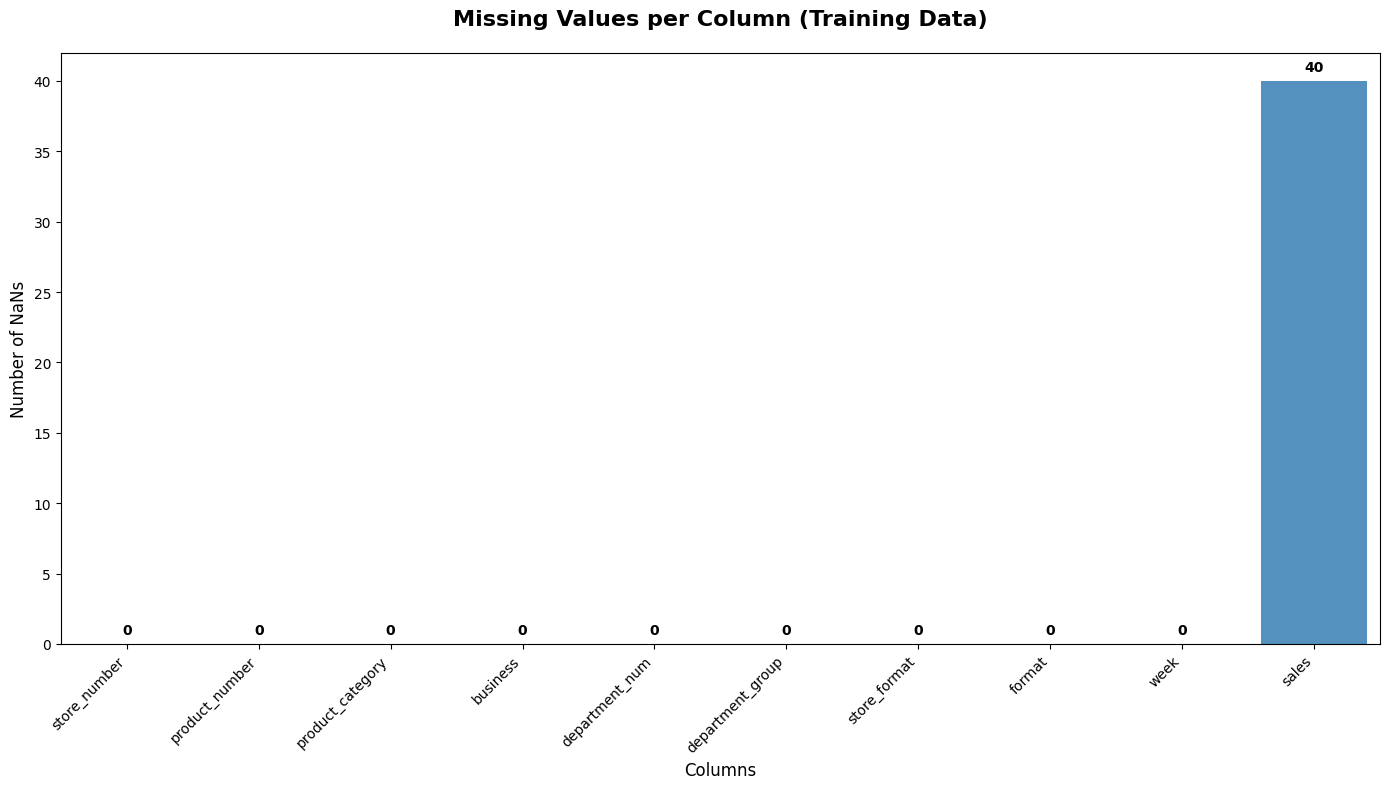

In [5]:
nan_counts = df_train.isna().sum()

plt.figure(figsize=(14, 8))
sns.barplot(x=nan_counts.index, y=nan_counts.values, color="#4293D0")

plt.title("Missing Values per Column (Training Data)", fontsize=16, fontweight='bold', pad=20)
plt.ylabel("Number of NaNs", fontsize=12)
plt.xlabel("Columns", fontsize=12)
plt.xticks(rotation=45, ha='right')

for i, val in enumerate(nan_counts.values):
    plt.text(i, val + 0.5, str(val), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('images/missing_values.png', dpi=300)
plt.show()

## Exploratory Data Analysis

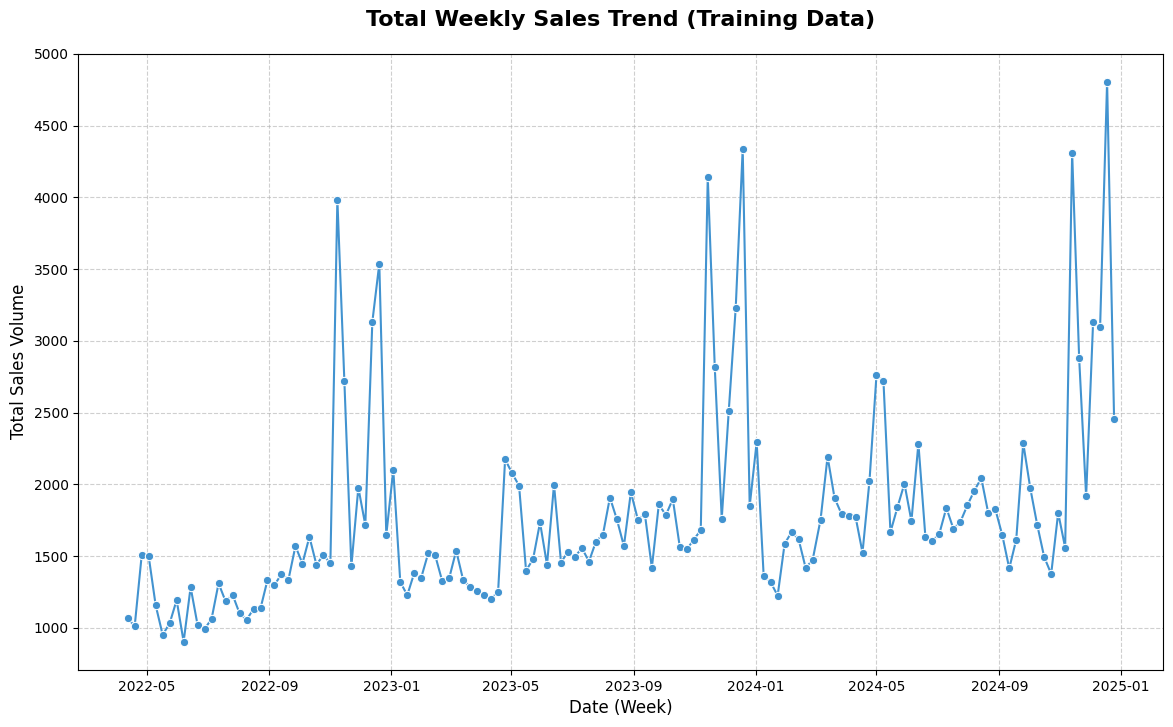

In [6]:
plt.figure(figsize=(14, 8))
weekly_sales = df_train.groupby('week')['sales'].sum().reset_index()
sns.lineplot(data=weekly_sales, x='week', y='sales', marker='o', color="#4293D0")
plt.title('Total Weekly Sales Trend (Training Data)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Date (Week)', fontsize=12)
plt.ylabel('Total Sales Volume', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig('images/time_series.png', dpi=300)
plt.show()

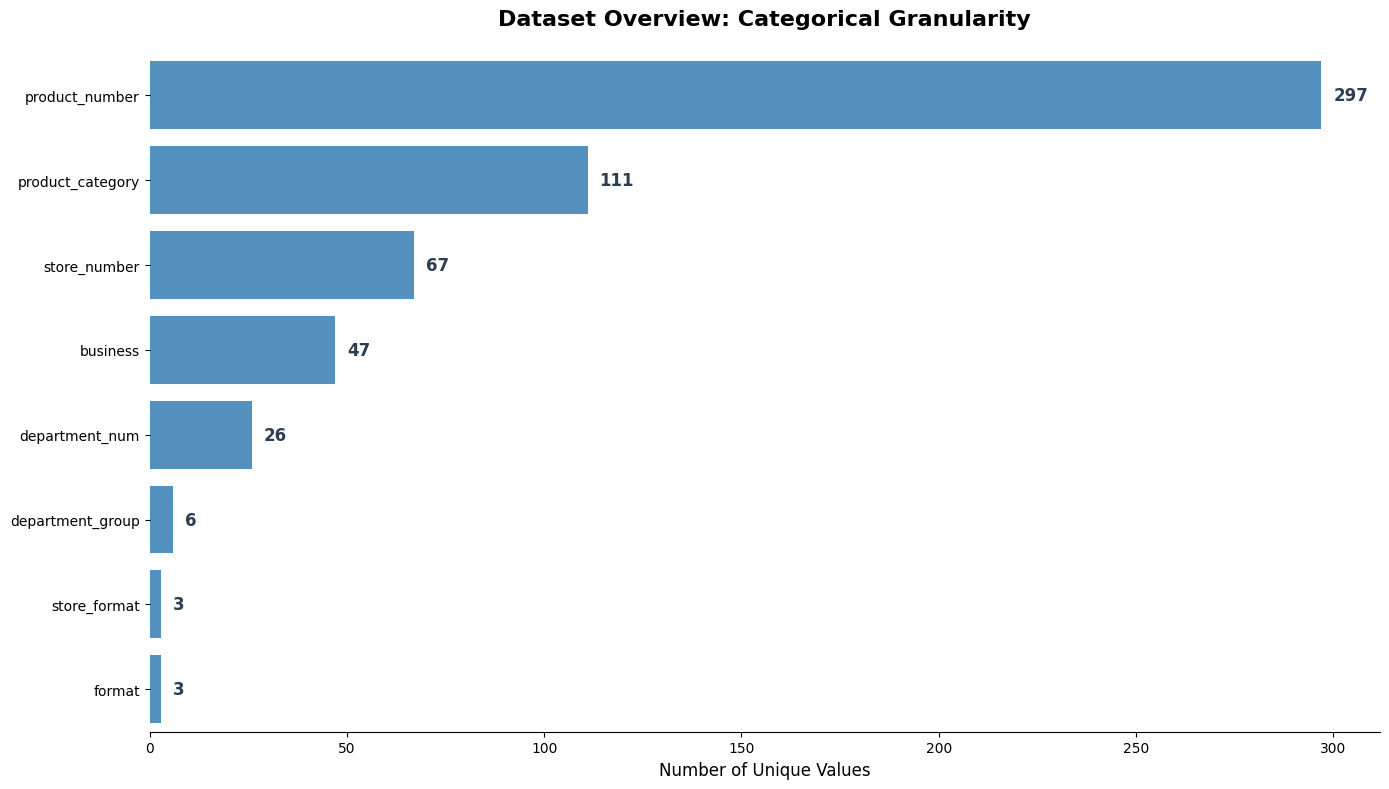

In [7]:
def display_dataset_summary_en(df):
    cols = [
        'product_number', 'product_category', 'business',
        'department_num', 'department_group', 'store_format', 'format', 'store_number'
    ]
    summary_data = [{'Dimension': col, 'Unique Count': df[col].nunique()} for col in cols]
    summary_df = pd.DataFrame(summary_data).sort_values('Unique Count', ascending=False)

    plt.figure(figsize=(14, 8))
    #sns.set_style("white") 
    
    target_blue = "#4293D0"

    ax = sns.barplot(
        x='Unique Count',
        y='Dimension',
        data=summary_df,
        color=target_blue
    )

    max_val = summary_df['Unique Count'].max()
    for p in ax.patches:
        width = p.get_width()
        plt.text(width + (max_val * 0.01), 
                 p.get_y() + p.get_height()/2,
                 f'{int(width):,}', 
                 va='center', fontsize=12, fontweight='bold', color='#2c3e50')

    plt.title('Dataset Overview: Categorical Granularity', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Number of Unique Values', fontsize=12)
    plt.ylabel('')
    
    sns.despine(left=True, bottom=False)

    plt.tight_layout()
    plt.savefig('images/unique_values_presentation.png', dpi=300)
    plt.show()

display_dataset_summary_en(df_train)

## Correlation store_format and format

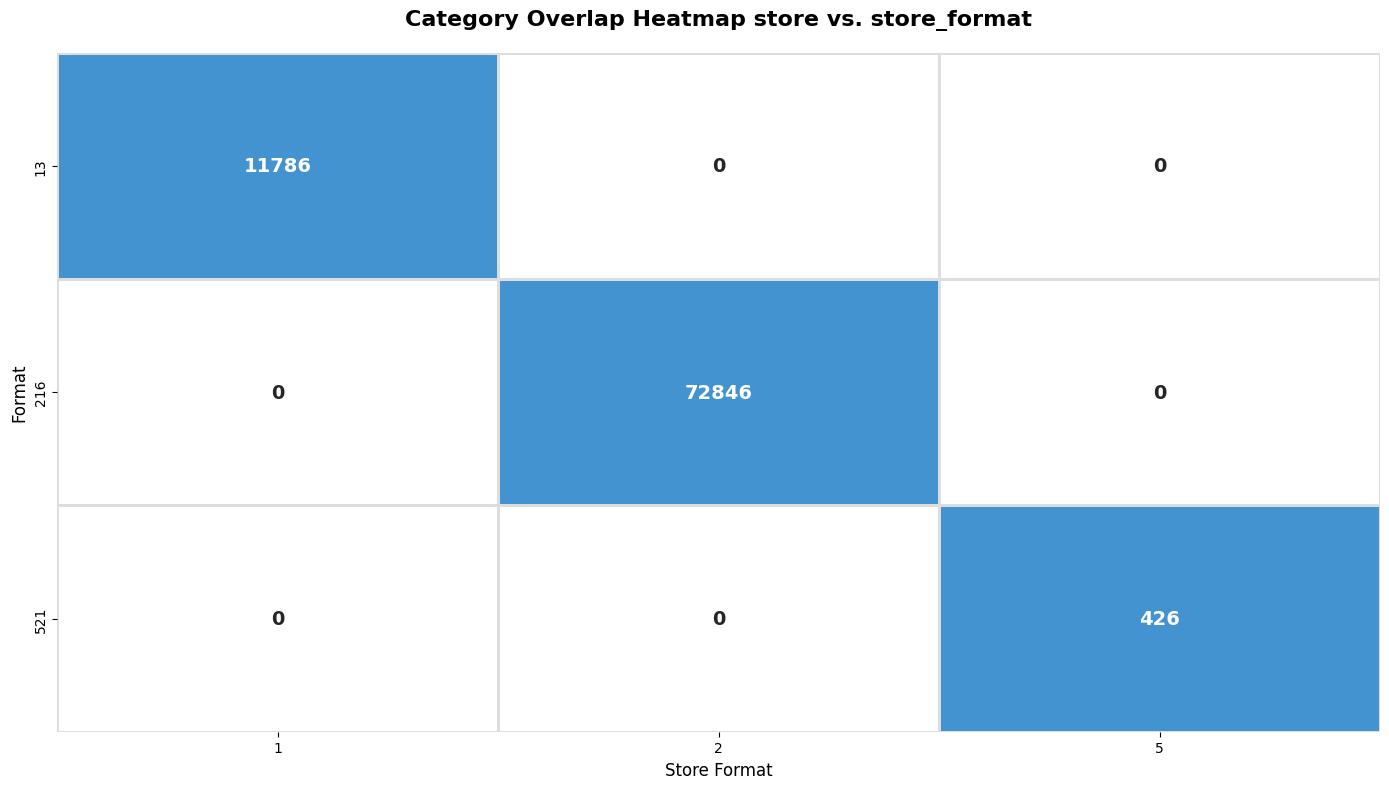

In [8]:
contingency_table = pd.crosstab(df_train['format'], df_train['store_format'])

target_blue = "#4293D0"
binary_cmap = ListedColormap(['#ffffff', target_blue])

plt.figure(figsize=(14, 8))

# Create the heatmap
sns.heatmap(contingency_table, 
            annot=True, 
            fmt='d', 
            cmap=binary_cmap, 
            vmin=0, 
            vmax=1, 
            cbar=False, 
            linewidths=1, 
            linecolor='#DDDDDD',
            # Set font size to 14 and keep it bold for visibility
            annot_kws={"size": 14, "weight": "bold"})

# Spearman correlation
correlation_value = df_train['store_format'].astype('category').cat.codes.corr(
    df_train['format'].astype('category').cat.codes, method='spearman')

plt.title(f'Category Overlap Heatmap store vs. store_format', 
          fontsize=16, 
          pad=20,
          fontweight='bold')

plt.xlabel('Store Format', fontsize=12)
plt.ylabel('Format', fontsize=12)

plt.tight_layout()
plt.savefig("images/correlation_format_store-format.png", dpi=300)
plt.show()

In [9]:
X_train_preprocessed = data_loader.preprocessing(df_train)
X_test_preprocessed = data_loader.preprocessing(df_test)

X_train_preprocessed.dtypes

store_number                 int64
product_number               int64
product_category             int64
business                     int64
department_num               int64
department_group             int64
store_format                 int64
week                datetime64[ns]
sales                      float64
month                        int32
week_of_year                 int64
year                         int64
dtype: object

/var/folders/f2/2y22t7gx2z5gdwk3d89ytmy00000gn/T/ipykernel_67650/67874065.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  peaks = weekly_sales.groupby('year').apply(lambda x: x.nlargest(2, 'sales')).reset_index(drop=True)


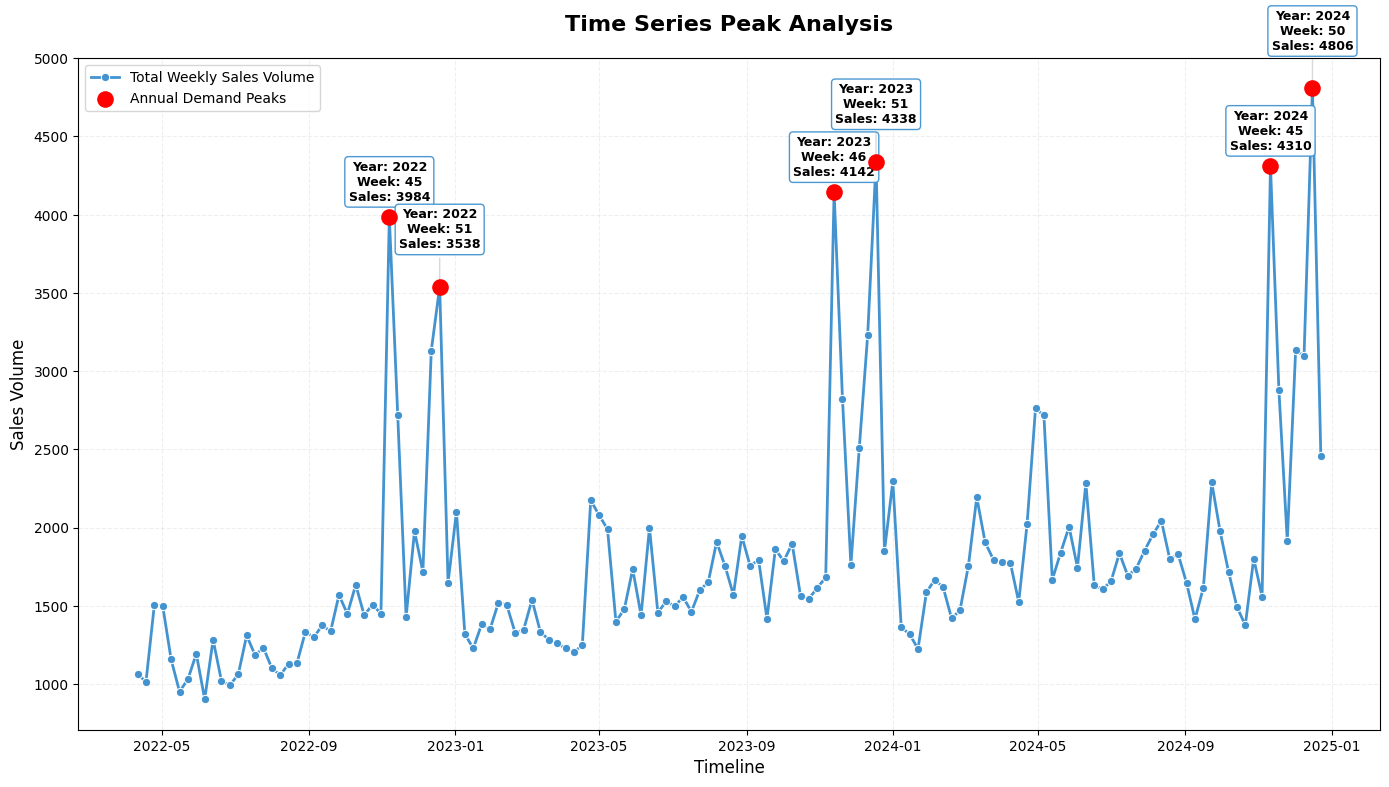

In [10]:
weekly_sales = X_train_preprocessed.groupby(['year', 'week'])['sales'].sum().reset_index()

peaks = weekly_sales.groupby('year').apply(lambda x: x.nlargest(2, 'sales')).reset_index(drop=True)
peaks = peaks.sort_values('week')

target_blue = "#4293D0"

plt.figure(figsize=(14, 8))

sns.lineplot(
    data=weekly_sales, 
    x='week', 
    y='sales', 
    marker='o', 
    color=target_blue, 
    linewidth=2, 
    label='Total Weekly Sales Volume'
)

plt.scatter(peaks['week'], peaks['sales'], color='red', s=120, zorder=5, label='Annual Demand Peaks')

for i, (_, row) in enumerate(peaks.iterrows()):
    week_num = row['week'].strftime('%U')
    
    # Smaller offsets to pull the boxes closer to the points
    y_offset = 12 if i % 2 == 0 else 28
    
    plt.annotate(
        f"Year: {int(row['year'])}\nWeek: {week_num}\nSales: {int(row['sales'])}",
        xy=(row['week'], row['sales']),
        xytext=(0, y_offset), 
        textcoords='offset points',
        ha='center',
        fontsize=9,
        fontweight='bold',
        # Subtle arrow to maintain the link without clutter
        arrowprops=dict(arrowstyle='-', color='gray', alpha=0.3),
        # Professional thin-border box in your target blue
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec=target_blue, lw=1, alpha=0.95)
    )

plt.title('Time Series Peak Analysis', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Timeline', fontsize=12)
plt.ylabel('Sales Volume', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.2)
plt.legend(loc='upper left')

plt.tight_layout()
plt.savefig('images/final_time_series_2peaks.png', dpi=300)
plt.show()

## Store Variety

/var/folders/f2/2y22t7gx2z5gdwk3d89ytmy00000gn/T/ipykernel_67650/894235783.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


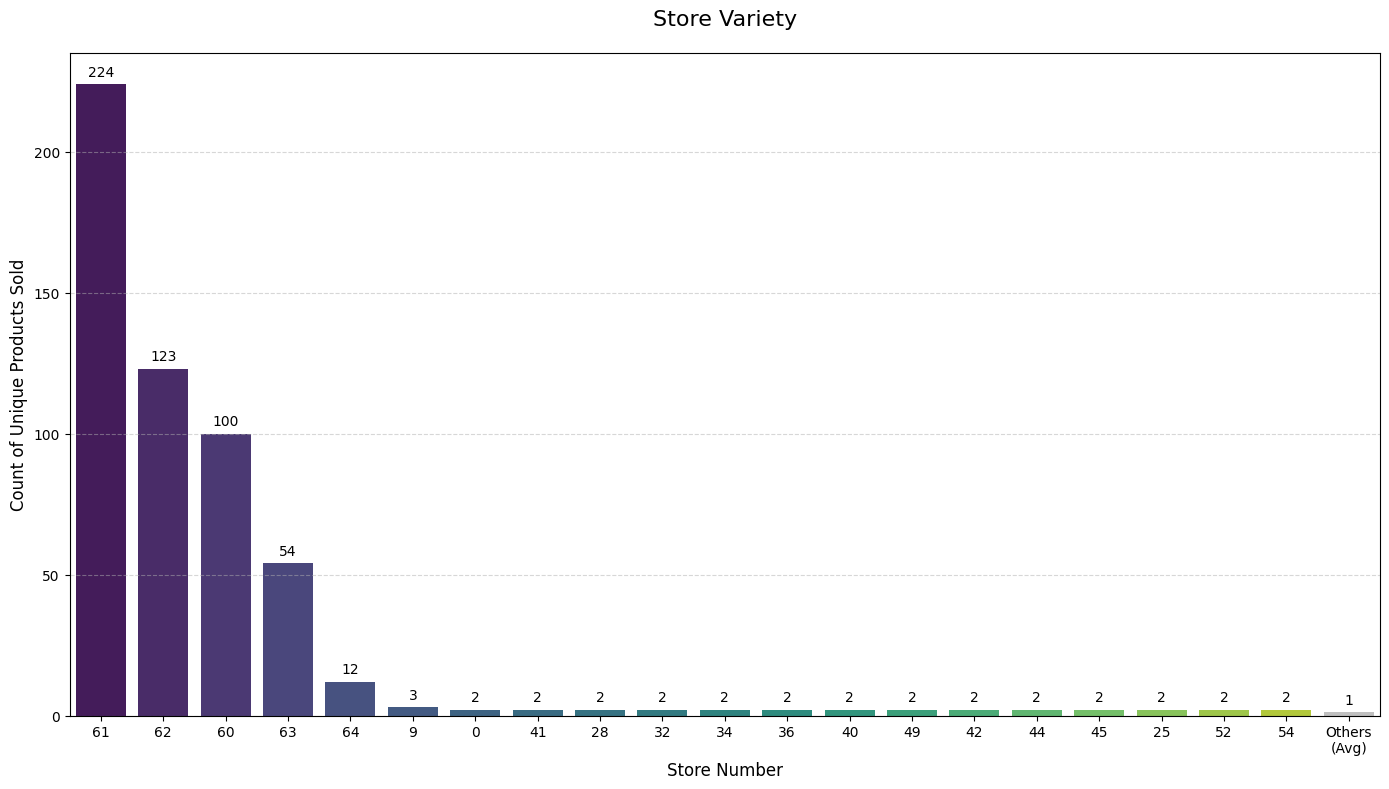

In [11]:
store_total_variety = X_train_preprocessed[X_train_preprocessed['sales'] > 0].groupby('store_number')['product_number'].nunique().sort_values(ascending=False).reset_index()
store_total_variety.columns = ['store_number', 'total_unique_products']

top_n = 20

if len(store_total_variety) > top_n:
    # Extract Top N stores
    top_stores = store_total_variety.head(top_n).copy()

    others_val = store_total_variety.iloc[top_n:]['total_unique_products'].mean()

    # Combine smaller stores
    others_df = pd.DataFrame({
        'store_number': ['Others\n(Avg)'],
        'total_unique_products': [others_val]
    })

    plot_data = pd.concat([top_stores, others_df], ignore_index=True)
else:
    plot_data = store_total_variety

plt.figure(figsize=(14, 8))
sns.barplot(
    data=plot_data,
    x='store_number',
    y='total_unique_products',
    palette='viridis'
)

if len(store_total_variety) > top_n:
    plt.gca().patches[-1].set_facecolor('gray')
    plt.gca().patches[-1].set_alpha(0.5)

plt.title(f'Store Variety', fontsize=16, pad=20)
plt.xlabel('Store Number', fontsize=12)
plt.ylabel('Count of Unique Products Sold', fontsize=12)
#plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Add value labels
for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}',
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha = 'center', va = 'center',
                       xytext = (0, 9),
                       textcoords = 'offset points',
                       fontsize=10)

plt.tight_layout()
plt.savefig('images/store_variety.png')
plt.show()

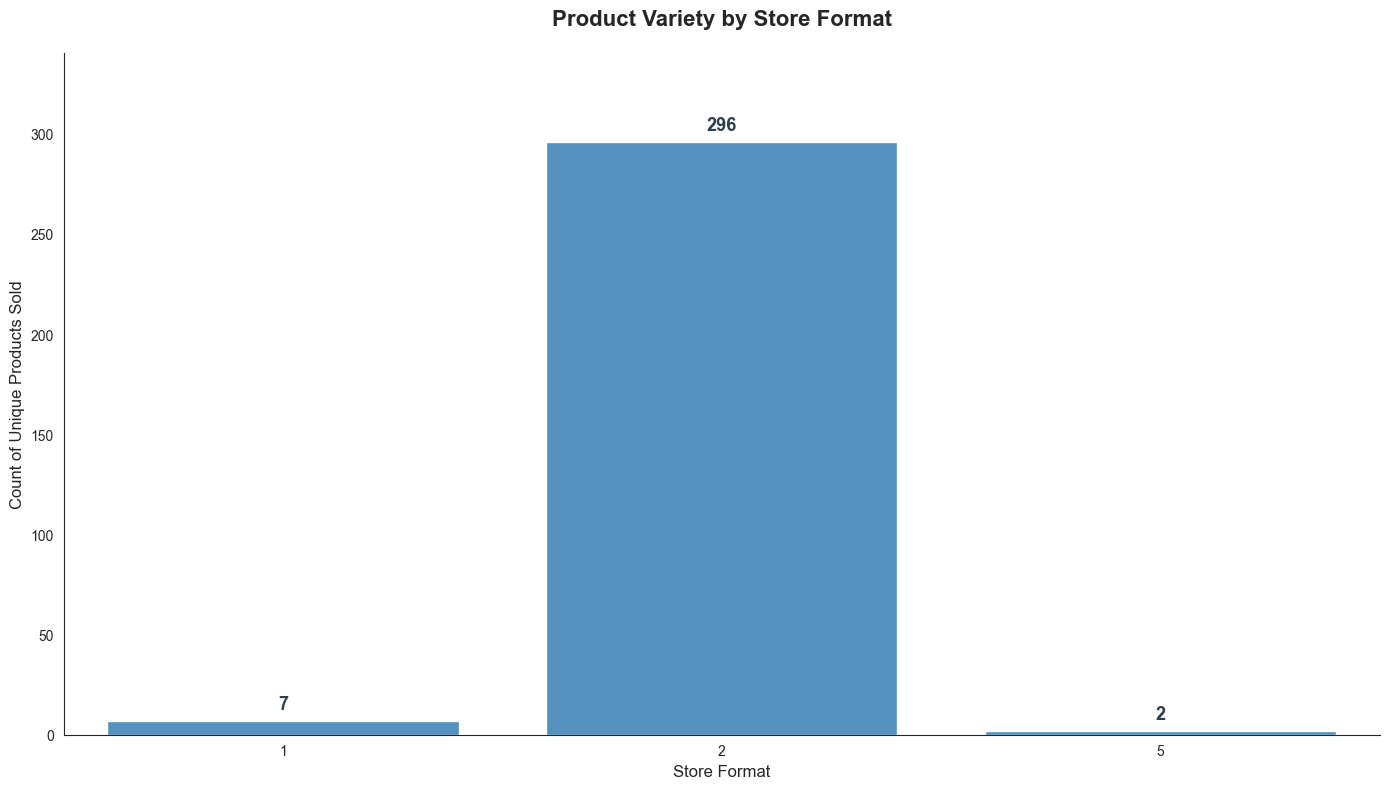

In [12]:
format_variety = (
    X_train_preprocessed[X_train_preprocessed['sales'] > 0]
    .groupby('store_format')['product_number']
    .nunique()
    .sort_values(ascending=False)
    .reset_index()
)
format_variety.columns = ['store_format', 'unique_products']

plt.figure(figsize=(14, 8))
sns.set_style("white")
target_blue = "#4293D0"

ax = sns.barplot(
    data=format_variety,
    x='store_format',
    y='unique_products',
    color=target_blue
)

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height):,}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center',
                xytext=(0, 12),
                textcoords='offset points',
                fontsize=13, fontweight='bold', color='#2c3e50')

plt.title('Product Variety by Store Format', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Count of Unique Products Sold', fontsize=12)
plt.xlabel('Store Format', fontsize=12)

plt.ylim(0, format_variety['unique_products'].max() * 1.15)

sns.despine()

plt.tight_layout()
plt.savefig('images/store_format_variety.png', dpi=300)
plt.show()

/var/folders/f2/2y22t7gx2z5gdwk3d89ytmy00000gn/T/ipykernel_67650/1928865507.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=X_train_preprocessed, x='store_format', y='sales', palette='Set2')


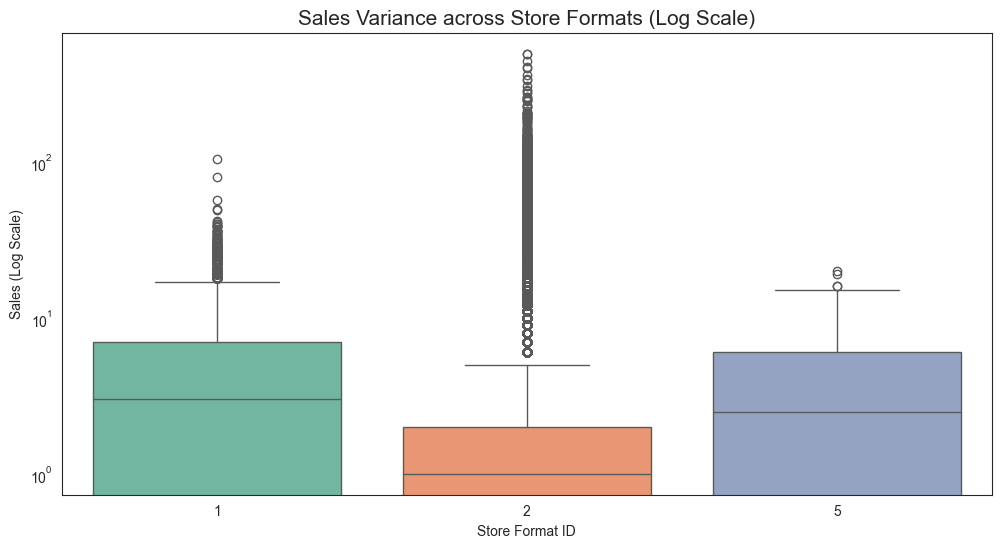

In [13]:
plt.figure(figsize=(12, 6))

sns.boxplot(data=X_train_preprocessed, x='store_format', y='sales', palette='Set2')
plt.yscale('log')
plt.title('Sales Variance across Store Formats (Log Scale)', fontsize=15)
plt.xlabel('Store Format ID')
plt.ylabel('Sales (Log Scale)')
plt.savefig('images/boxplot_store_format_variance.png')
plt.show()

/var/folders/f2/2y22t7gx2z5gdwk3d89ytmy00000gn/T/ipykernel_67650/544766282.py:28: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(


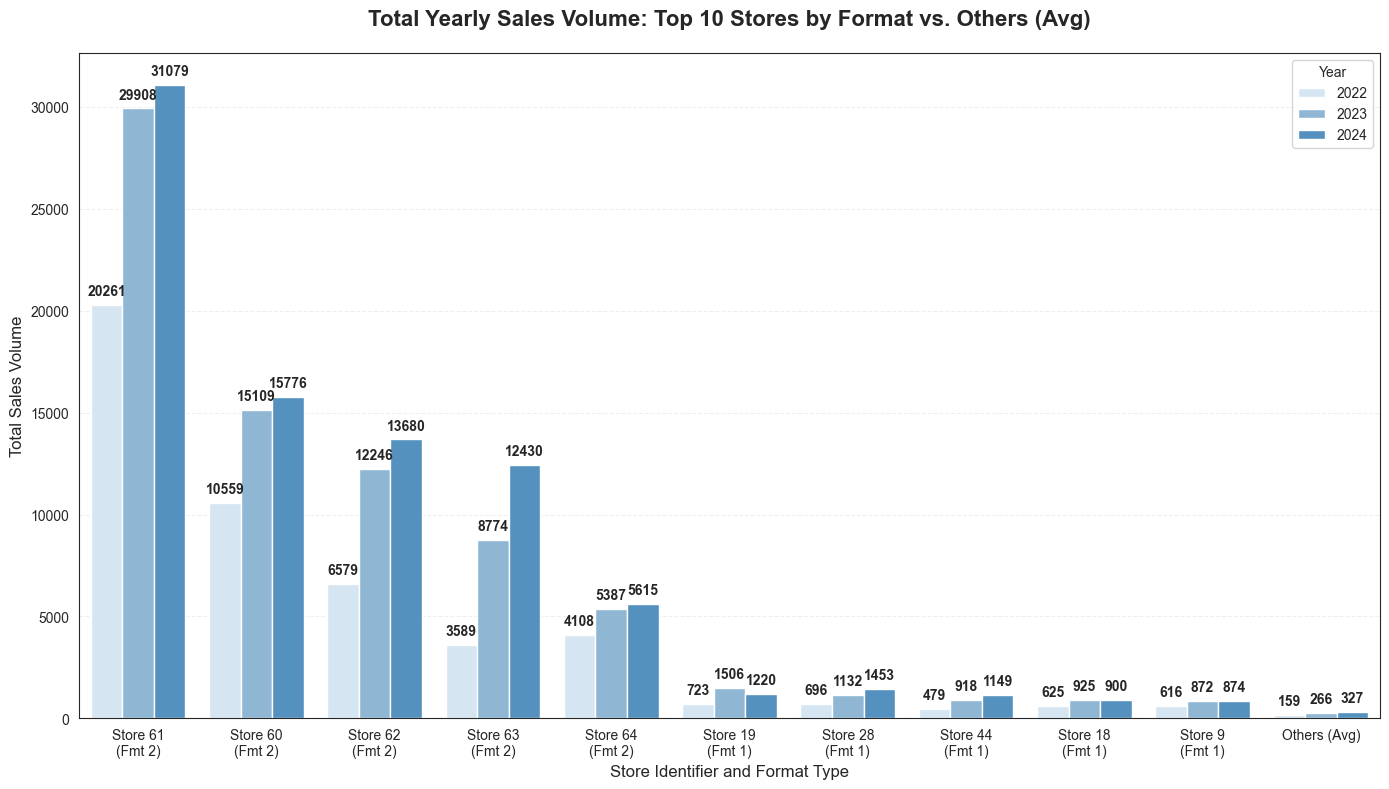

In [14]:
store_format_mapping = X_train_preprocessed[['store_number', 'store_format']].drop_duplicates()
store_yearly_sales = X_train_preprocessed.groupby(['store_number', 'year'])['sales'].sum().reset_index()

top_n = 10
top_stores_list = store_yearly_sales.groupby('store_number')['sales'].sum().nlargest(top_n).index

top_stores_df = store_yearly_sales[store_yearly_sales['store_number'].isin(top_stores_list)].copy()
top_stores_df = top_stores_df.merge(store_format_mapping, on='store_number', how='left')

top_stores_df['display_label'] = "Store " + top_stores_df['store_number'].astype(str) + \
                                 "\n(Fmt " + top_stores_df['store_format'].astype(str) + ")"

others_df = store_yearly_sales[~store_yearly_sales['store_number'].isin(top_stores_list)].copy()
others_yearly = others_df.groupby('year')['sales'].mean().reset_index()
others_yearly['display_label'] = 'Others (Avg)'

plot_data = pd.concat([top_stores_df, others_yearly], ignore_index=True)

order = top_stores_df.groupby('display_label')['sales'].sum().sort_values(ascending=False).index.tolist()
order.append('Others (Avg)')

target_blue = "#4293D0"
num_years = plot_data['year'].nunique()
colors_list = ["#D0E6F7", "#84B9E0", target_blue]
custom_palette = LinearSegmentedColormap.from_list("custom_blues", colors_list)(np.linspace(0, 1, num_years))

plt.figure(figsize=(14, 8))
sns.barplot(
    data=plot_data,
    x='display_label',
    y='sales',
    hue='year',
    palette=custom_palette, 
    order=order
)

plt.title(f'Total Yearly Sales Volume: Top {top_n} Stores by Format vs. Others (Avg)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Store Identifier and Format Type', fontsize=12)
plt.ylabel('Total Sales Volume', fontsize=12)
plt.legend(title='Year', loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.3)

for p in plt.gca().patches:
    height = p.get_height()
    if height > 0:
        plt.gca().annotate(f'{int(height)}',
                           (p.get_x() + p.get_width() / 2., height),
                           ha='center', va='center',
                           xytext=(0, 10),
                           textcoords='offset points',
                           fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('images/yearly_sales_volume_stores.png')
plt.show()

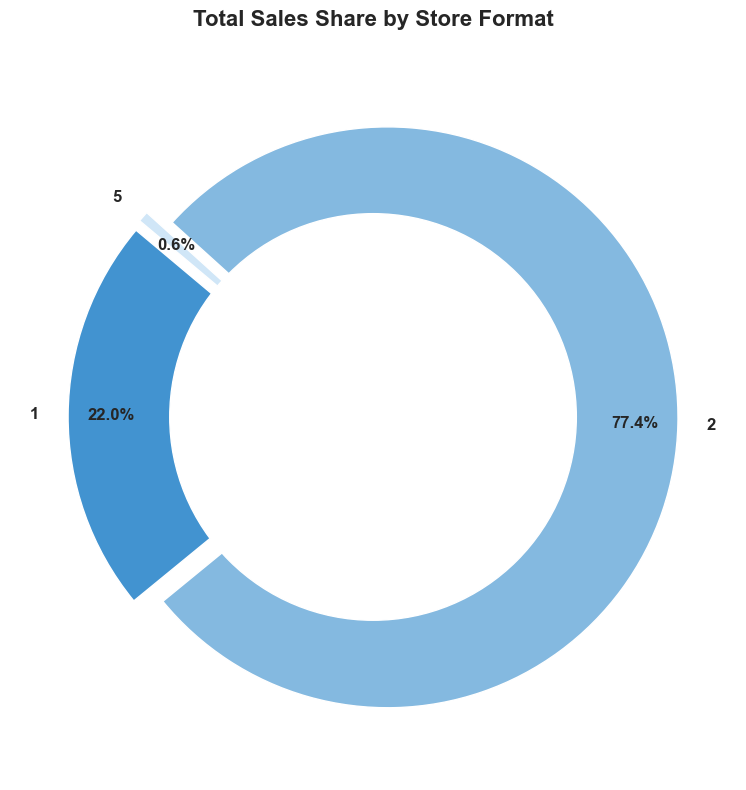

In [15]:
format_shares = X_train_preprocessed.groupby('store_format')['sales'].sum().reset_index()

plt.figure(figsize=(14, 8))
target_blue = "#4293D0"

colors = [target_blue, "#84B9E0", "#D0E6F7"] 

# Pie Chart
plt.pie(
    format_shares['sales'], 
    labels=format_shares['store_format'], 
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    pctdistance=0.85,
    explode=[0.05] * len(format_shares),
    textprops={'fontsize': 12, 'fontweight': 'bold'}
)

centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Total Sales Share by Store Format', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('images/sales_share_pie.png', dpi=300)
plt.show()

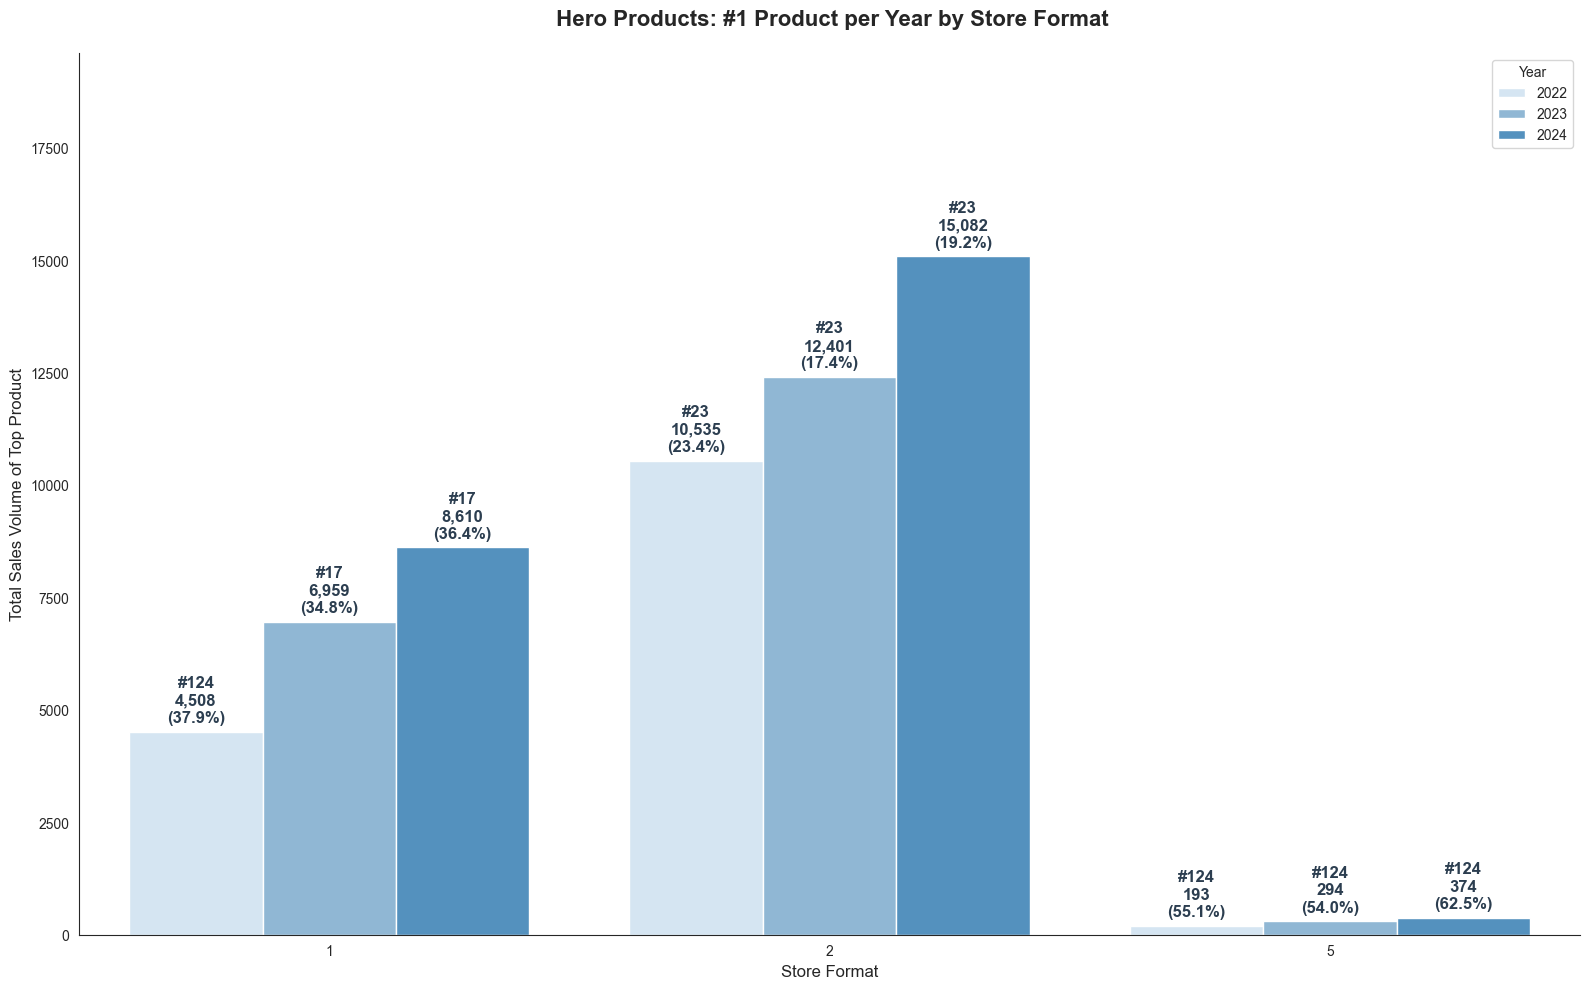

In [16]:
# Calculate Total Sales per Format per Year (The Denominator)
format_yearly_totals = (
    X_train_preprocessed.groupby(['store_format', 'year'])['sales']
    .sum()
    .reset_index()
    .rename(columns={'sales': 'total_format_sales'})
)

# Get the #1 product for each format and year
yearly_heroes = (
    X_train_preprocessed.groupby(['store_format', 'year', 'product_number'])['sales']
    .sum()
    .reset_index()
    .sort_values(['store_format', 'year', 'sales'], ascending=[True, True, False])
)
top_1_per_year = yearly_heroes.groupby(['store_format', 'year']).head(1)

# Merge and Calculate Share Percentage
top_1_per_year = top_1_per_year.merge(format_yearly_totals, on=['store_format', 'year'])
top_1_per_year['share_pct'] = (top_1_per_year['sales'] / top_1_per_year['total_format_sales']) * 100

# Plotting
plt.figure(figsize=(16, 10))
sns.set_style("white")
target_blue = "#4293D0"

ax = sns.barplot(
    data=top_1_per_year, 
    x='store_format', 
    y='sales', 
    hue='year', 
    palette=["#D0E6F7", "#84B9E0", target_blue],
    errorbar=None
)

for i, p in enumerate(ax.patches):
    height = p.get_height()
    if height > 0:
        num_formats = len(top_1_per_year['store_format'].unique())
        year_idx = i // num_formats
        fmt_idx = i % num_formats
        
        years_list = sorted(top_1_per_year['year'].unique())
        formats_list = top_1_per_year['store_format'].unique()
        
        current_year = years_list[year_idx]
        current_fmt = formats_list[fmt_idx]
        
        row = top_1_per_year[
            (top_1_per_year['store_format'] == current_fmt) & 
            (top_1_per_year['year'] == current_year)
        ]
        
        if not row.empty:
            prod_num = row['product_number'].values[0]
            share = row['share_pct'].values[0]
            
            plt.text(p.get_x() + p.get_width() / 2., 
                     height + (top_1_per_year['sales'].max() * 0.01),
                     f'#{int(prod_num)}\n{int(height):,}\n({share:.1f}%)', 
                     ha='center', va='bottom', 
                     fontsize=12, fontweight='bold', color='#2c3e50')

plt.title(' Hero Products: #1 Product per Year by Store Format', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Store Format', fontsize=12)
plt.ylabel('Total Sales Volume of Top Product', fontsize=12)
plt.legend(title='Year', loc='upper right', frameon=True)

plt.ylim(0, top_1_per_year['sales'].max() * 1.3)
sns.despine()
plt.tight_layout()
plt.savefig('images/dynamic_yearly_heroes.png', dpi=300)
plt.show()

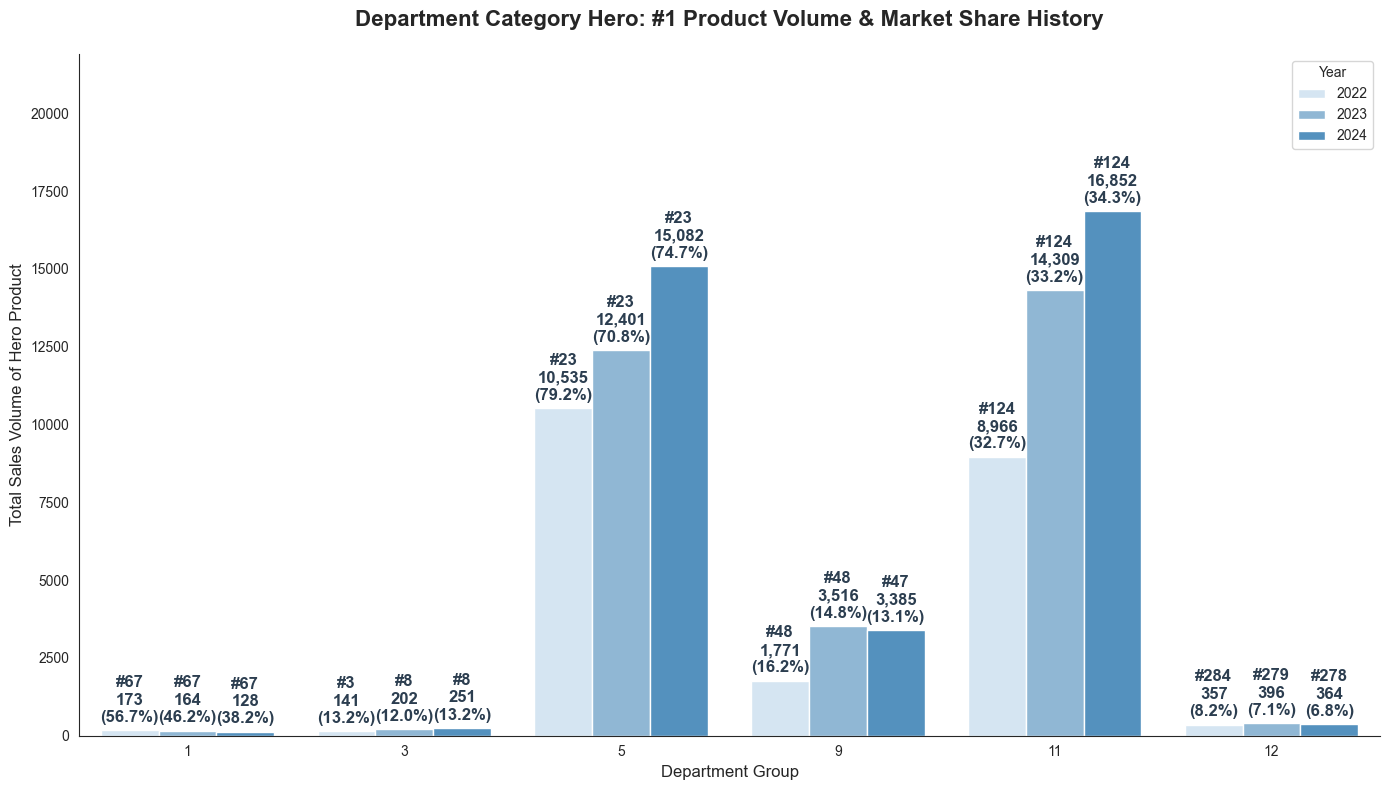

In [17]:
dept_yearly_totals = (
    X_train_preprocessed.groupby(['department_group', 'year'])['sales']
    .sum()
    .reset_index()
    .rename(columns={'sales': 'total_dept_sales'})
)

yearly_dept_heroes = (
    X_train_preprocessed.groupby(['department_group', 'year', 'product_number'])['sales']
    .sum()
    .reset_index()
    .sort_values(['department_group', 'year', 'sales'], ascending=[True, True, False])
)

top_1_dept_year = yearly_dept_heroes.groupby(['department_group', 'year']).head(1)

top_1_dept_year = top_1_dept_year.merge(dept_yearly_totals, on=['department_group', 'year'])
top_1_dept_year['share_pct'] = (top_1_dept_year['sales'] / top_1_dept_year['total_dept_sales']) * 100

plt.figure(figsize=(14, 8))
sns.set_style("white")
target_blue = "#4293D0"

ax = sns.barplot(
    data=top_1_dept_year, 
    x='department_group', 
    y='sales', 
    hue='year', 
    palette=["#D0E6F7", "#84B9E0", target_blue],
    errorbar=None
)

for i, p in enumerate(ax.patches):
    height = p.get_height()
    if height > 0:
        # Determine current group based on patch order
        num_depts = len(top_1_dept_year['department_group'].unique())
        year_idx = i // num_depts
        dept_idx = i % num_depts
        
        years_list = sorted(top_1_dept_year['year'].unique())
        depts_list = top_1_dept_year['department_group'].unique()
        
        current_year = years_list[year_idx]
        current_dept = depts_list[dept_idx]
        
        row = top_1_dept_year[
            (top_1_dept_year['department_group'] == current_dept) & 
            (top_1_dept_year['year'] == current_year)
        ]
        
        if not row.empty:
            prod_num = row['product_number'].values[0]
            share = row['share_pct'].values[0]
            
            plt.text(p.get_x() + p.get_width() / 2., 
                     height + (top_1_dept_year['sales'].max() * 0.01),
                     f'#{int(prod_num)}\n{int(height):,}\n({share:.1f}%)', 
                     ha='center', va='bottom', 
                     fontsize=12, fontweight='bold', color='#2c3e50')

# Formatting for a clean slide look
plt.title('Department Category Hero: #1 Product Volume & Market Share History', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Department Group', fontsize=12)
plt.ylabel('Total Sales Volume of Hero Product', fontsize=12)
plt.legend(title='Year', loc='upper right', frameon=True)

plt.ylim(0, top_1_dept_year['sales'].max() * 1.3)
sns.despine()
plt.tight_layout()

plt.savefig('images/department_yearly_heroes.png', dpi=300)
plt.show()

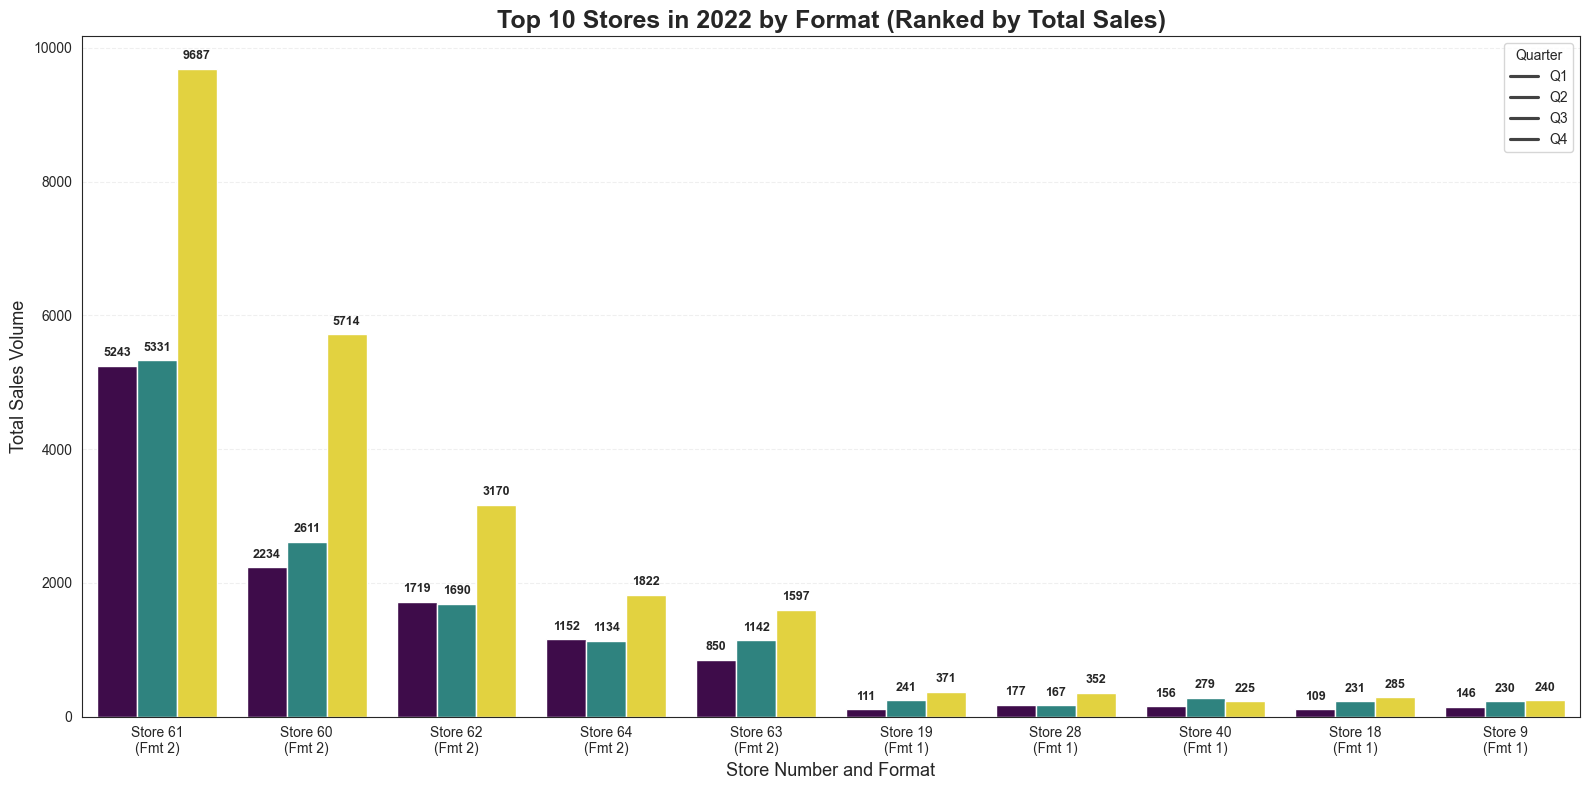

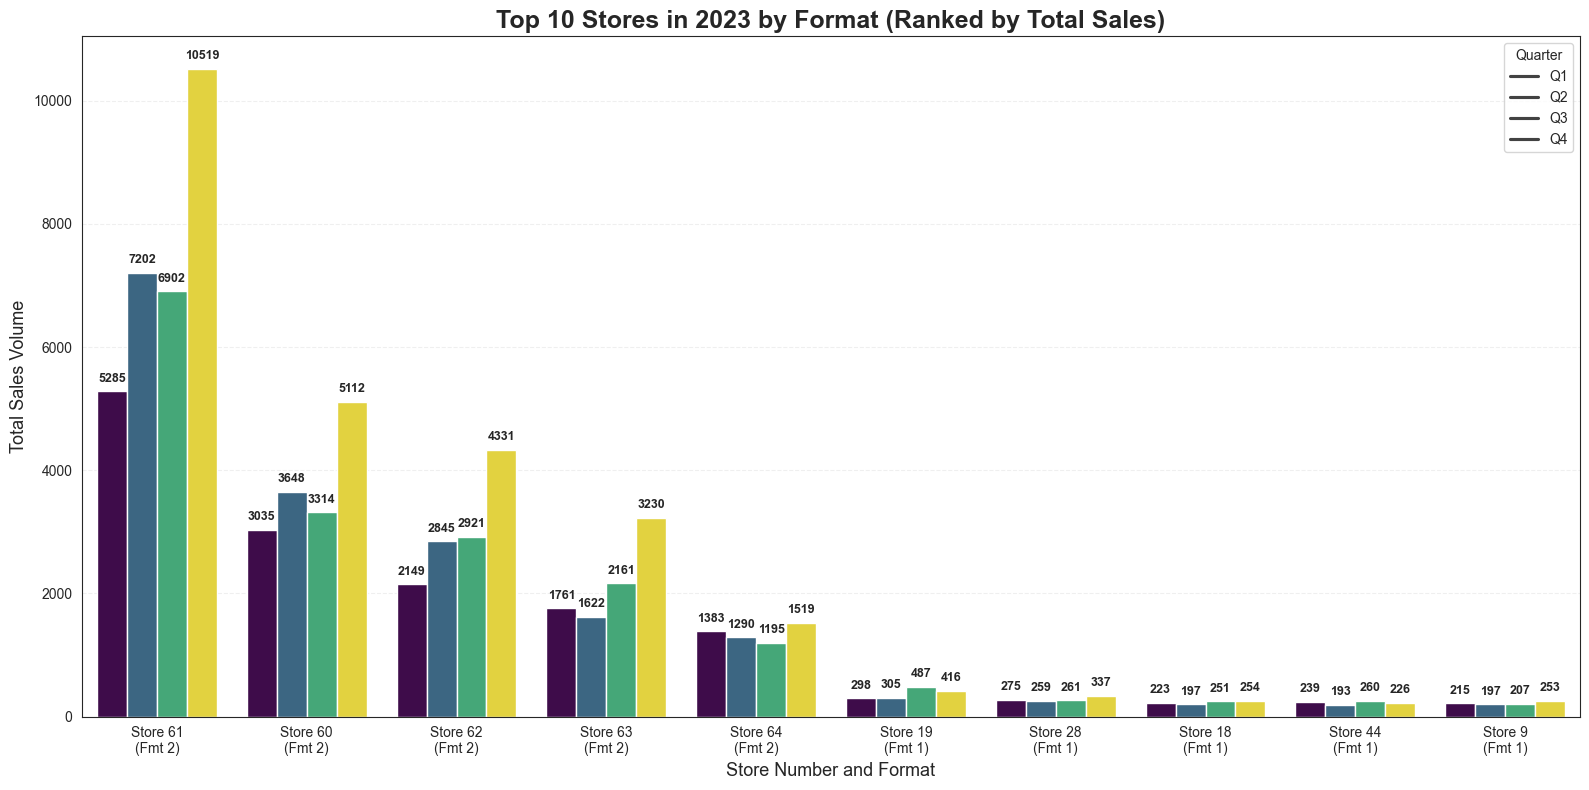

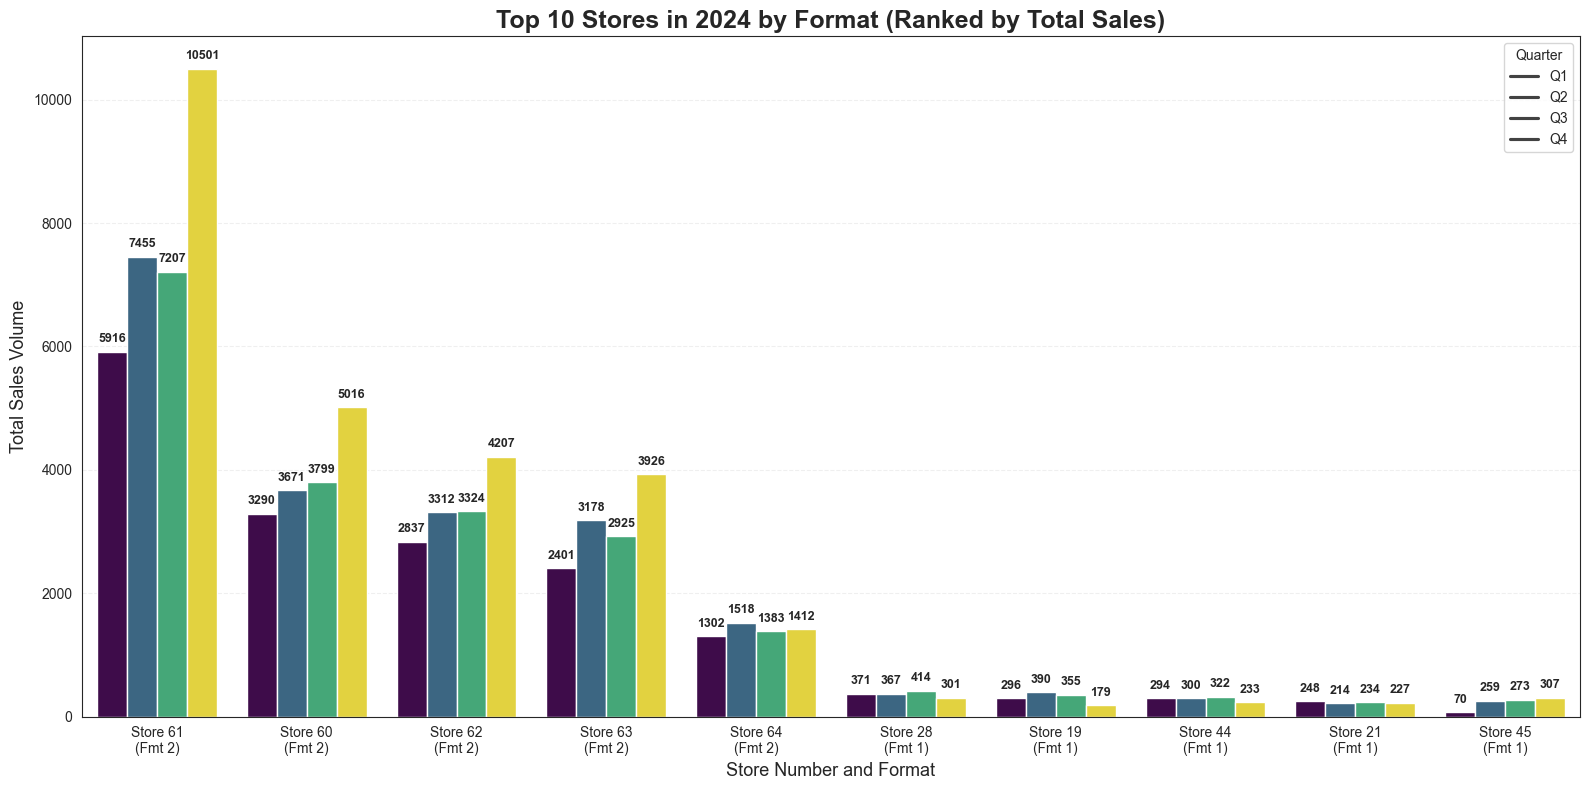

In [18]:
if 'quarter' not in X_train_preprocessed.columns:
    X_train_preprocessed['quarter'] = X_train_preprocessed['week'].dt.quarter

store_fmt_map = X_train_preprocessed[['store_number', 'store_format']].drop_duplicates()

yearly_store_stats = X_train_preprocessed.groupby(['year', 'store_number', 'quarter'])['sales'].sum().reset_index()

years = sorted(yearly_store_stats['year'].unique())

for year in years:
    year_data = yearly_store_stats[yearly_store_stats['year'] == year].copy()

    current_year_order = year_data.groupby('store_number')['sales'].sum().nlargest(10).index.tolist()

    plot_data = year_data[year_data['store_number'].isin(current_year_order)].copy()
    plot_data = plot_data.merge(store_fmt_map, on='store_number', how='left')

    plot_data['display_label'] = "Store " + plot_data['store_number'].astype(str) + \
                                 "\n(Fmt " + plot_data['store_format'].astype(str) + ")"

    # Re-calculate the order based on the new labels to keep the ranking
    label_order = [f"Store {s}\n(Fmt {store_fmt_map[store_fmt_map['store_number']==s]['store_format'].values[0]})"
                   for s in current_year_order]

    plt.figure(figsize=(16, 8))
    sns.barplot(
        data=plot_data,
        x="display_label",
        y="sales",
        hue="quarter",
        palette="viridis",
        order=label_order
    )

    # Styling
    plt.title(f'Top 10 Stores in {year} by Format (Ranked by Total Sales)', fontsize=18, fontweight='bold')
    plt.xlabel('Store Number and Format', fontsize=13)
    plt.ylabel('Total Sales Volume', fontsize=13)
    plt.legend(title="Quarter", labels=['Q1', 'Q2', 'Q3', 'Q4'], loc='upper right')
    plt.grid(axis='y', linestyle='--', alpha=0.3)

    # Value Labels
    for p in plt.gca().patches:
        height = p.get_height()
        if height > 0:
            plt.gca().annotate(f'{int(height)}',
                               (p.get_x() + p.get_width() / 2., height),
                               ha='center', va='center',
                               xytext=(0, 9),
                               textcoords='offset points',
                               fontsize=9,
                               fontweight='bold')

    plt.tight_layout()
    save_path = f'images/top_stores_{year}.png'
    plt.savefig(save_path)
    plt.show()

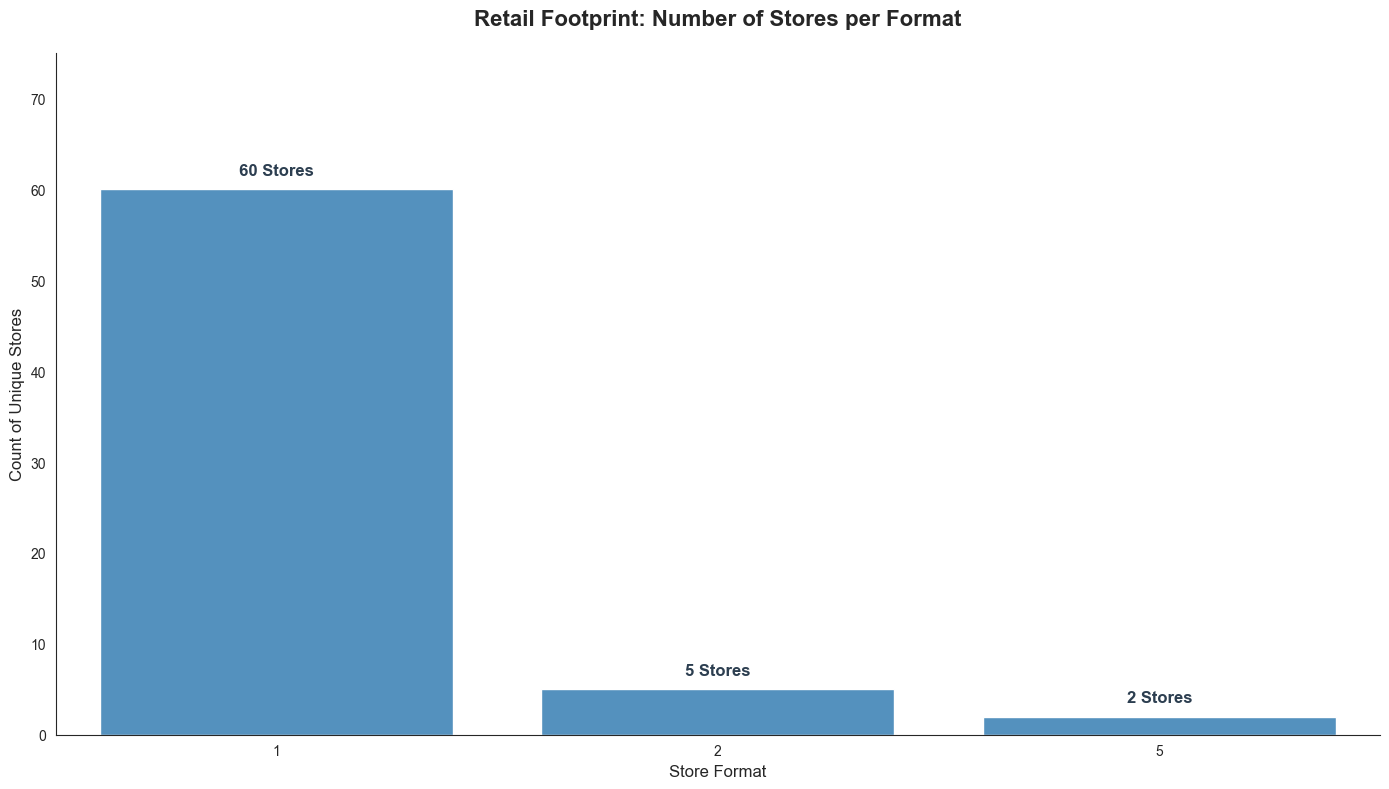

In [19]:
store_counts = df_train.groupby('store_format')['store_number'].nunique().reset_index()
store_counts.columns = ['store_format', 'store_count']
store_counts = store_counts.sort_values('store_count', ascending=False)

plt.figure(figsize=(14, 8))
sns.set_style("white")
target_blue = "#4293D0"

ax = sns.barplot(
    data=store_counts,
    x='store_format',
    y='store_count',
    color=target_blue
)

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)} Stores',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom',
                xytext=(0, 8),
                textcoords='offset points',
                fontsize=12, fontweight='bold', color='#2c3e50')

plt.title('Retail Footprint: Number of Stores per Format', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Store Format', fontsize=12)
plt.ylabel('Count of Unique Stores', fontsize=12)

# Add extra space at the top for labels
plt.ylim(0, store_counts['store_count'].max() * 1.25)

sns.despine()
plt.tight_layout()

# Save for your slide deck
plt.savefig('images/stores_per_format.png', dpi=300)
plt.show()

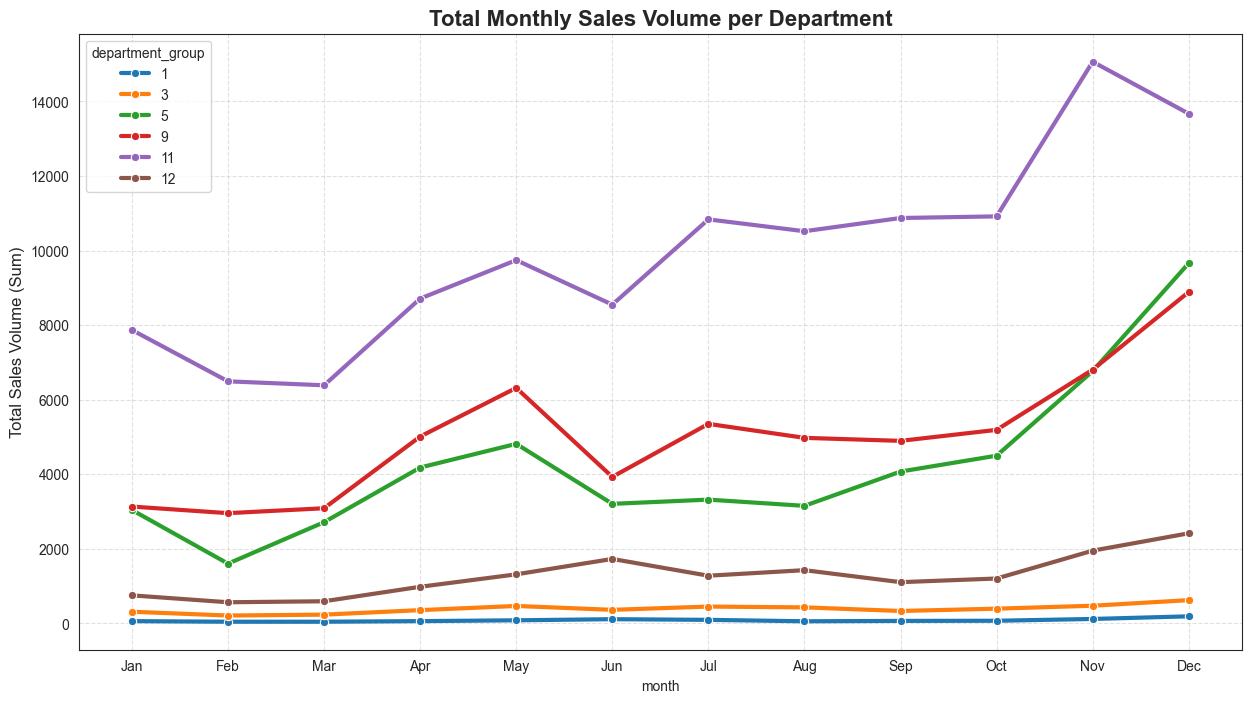

In [20]:
seasonal_sum = X_train_preprocessed.groupby(['department_group', 'month'])['sales'].sum().reset_index()

top_depts = X_train_preprocessed.groupby('department_group')['sales'].sum().index
plot_data = seasonal_sum[seasonal_sum['department_group'].isin(top_depts)]

plt.figure(figsize=(15, 8))
sns.lineplot(
    data=plot_data,
    x='month',
    y='sales',
    hue='department_group',
    marker='o',
    linewidth=3,
    palette="tab10"
)

plt.title('Total Monthly Sales Volume per Department', fontsize=16, fontweight='bold')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.ylabel('Total Sales Volume (Sum)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig("images/montly_sales_per_department.png")
plt.show()

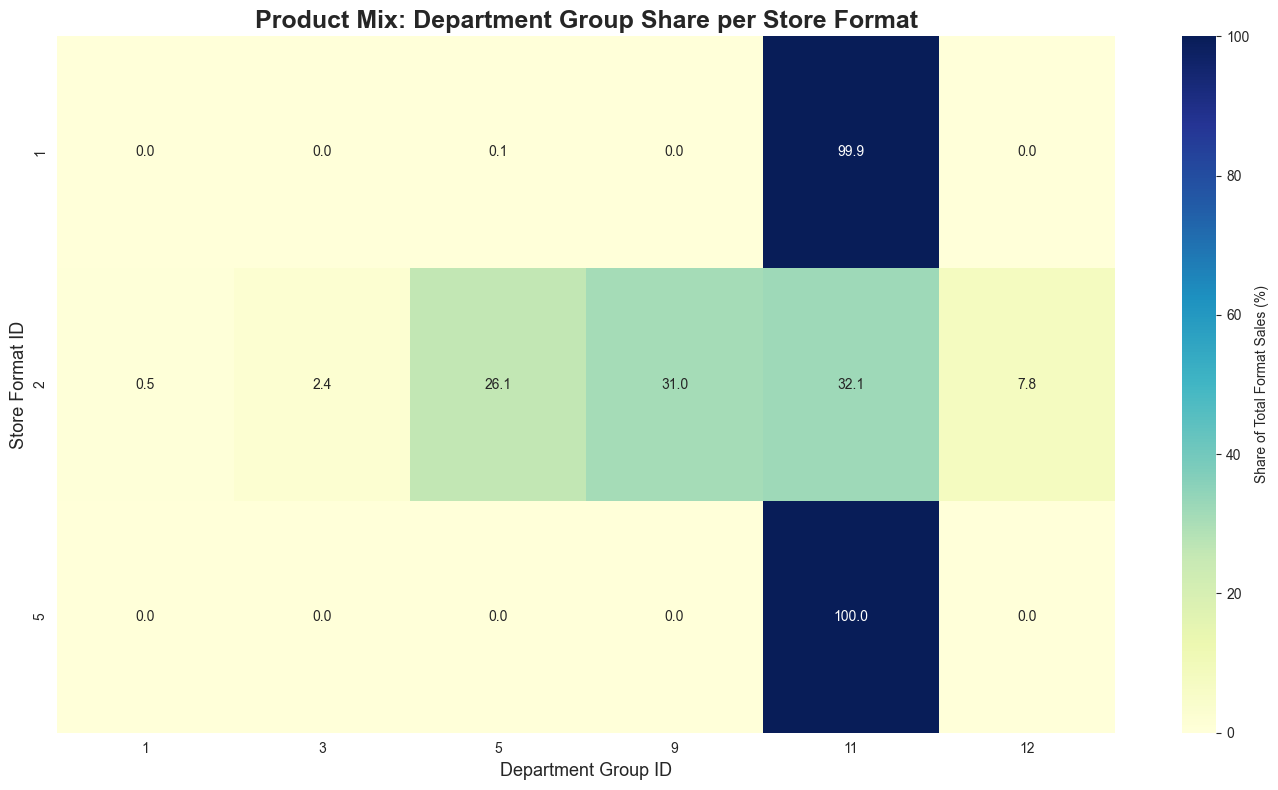

In [21]:
format_dept_sales = X_train_preprocessed.groupby(['store_format', 'department_group'])['sales'].sum().reset_index()

pivot_data = format_dept_sales.pivot(index='store_format', columns='department_group', values='sales').fillna(0)

pivot_norm = pivot_data.div(pivot_data.sum(axis=1), axis=0) * 100

plt.figure(figsize=(14, 8))
sns.heatmap(pivot_norm, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': 'Share of Total Format Sales (%)'})

plt.title('Product Mix: Department Group Share per Store Format', fontsize=18, fontweight='bold')
plt.xlabel('Department Group ID', fontsize=13)
plt.ylabel('Store Format ID', fontsize=13)

plt.tight_layout()
plt.savefig("images/product_mix_per_store_format.png")
plt.show()

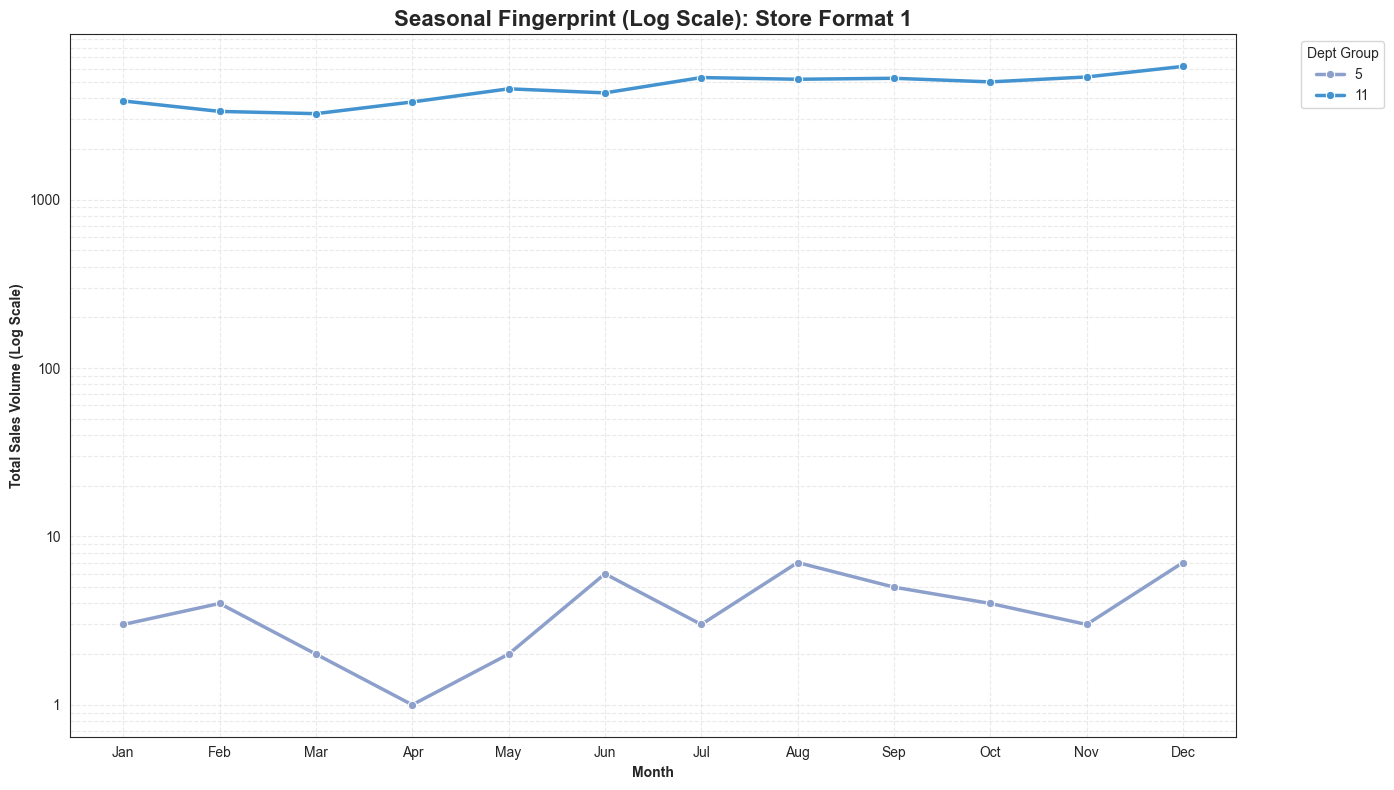

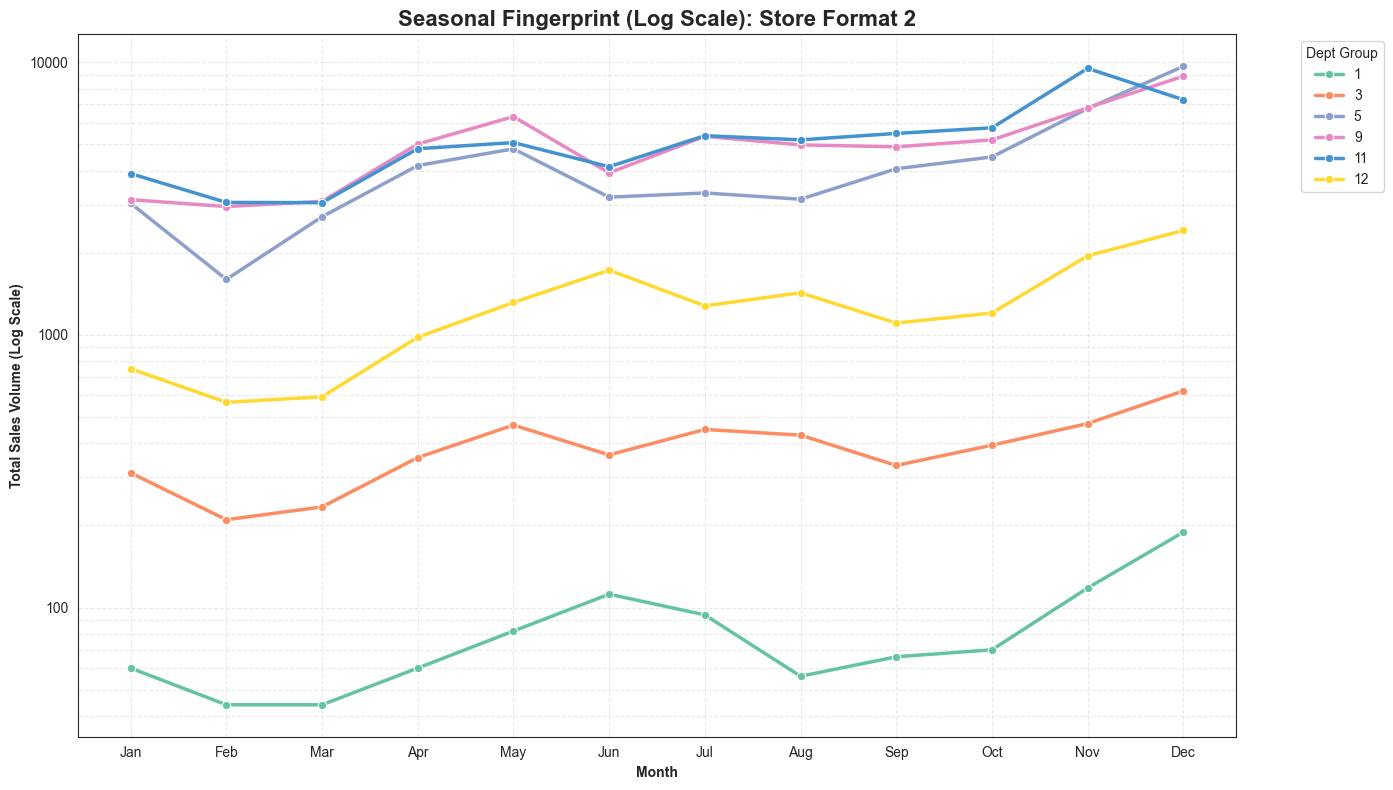

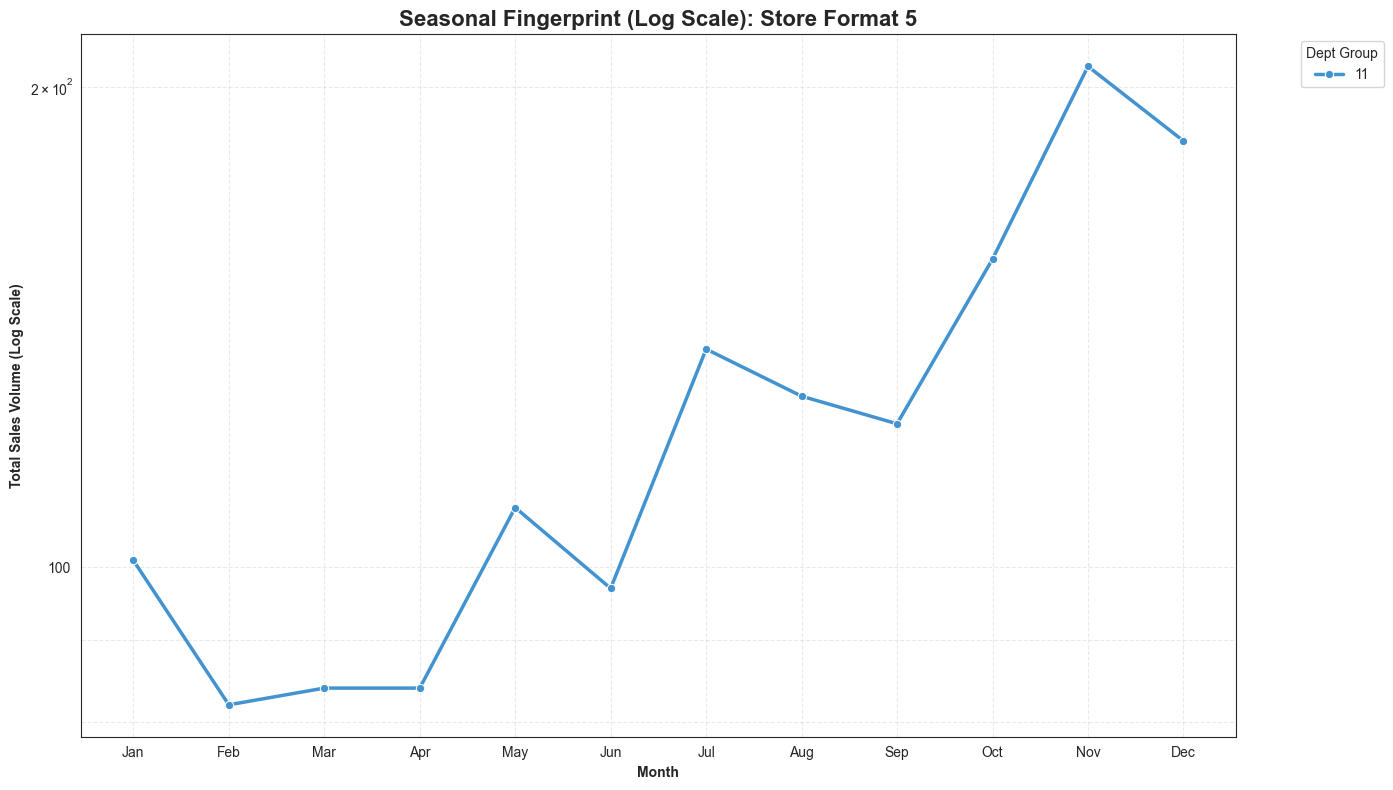

In [22]:
target_blue = "#4293D0"
all_depts = sorted(X_train_preprocessed['department_group'].unique())
base_colors = sns.color_palette("Set2", len(all_depts))
dept_color_map = {dept: base_colors[i] for i, dept in enumerate(all_depts)}

if 11 in dept_color_map:
    dept_color_map[11] = target_blue

unique_formats = sorted(X_train_preprocessed['store_format'].unique())

for fmt in unique_formats:
    format_data = X_train_preprocessed[X_train_preprocessed['store_format'] == fmt]
    fmt_seasonal = format_data.groupby(['department_group', 'month'])['sales'].sum().reset_index()

    plt.figure(figsize=(14, 8))
    
    sns.lineplot(
        data=fmt_seasonal,
        x='month',
        y='sales',
        hue='department_group',
        marker='o',
        linewidth=2.5,
        palette=dept_color_map
    )

    plt.yscale('log')
    
    plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter())
    plt.gca().yaxis.get_major_formatter().set_scientific(False)
    plt.gca().yaxis.get_major_formatter().set_useOffset(False)

    plt.title(f'Seasonal Fingerprint (Log Scale): Store Format {fmt}', fontsize=16, fontweight='bold')
    plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.ylabel('Total Sales Volume (Log Scale)', fontweight='bold')
    plt.xlabel('Month', fontweight='bold')
    
    plt.grid(True, which="both", linestyle='--', alpha=0.4)

    plt.legend(title='Dept Group', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    
    save_path = f'images/seasonal_fingerprint_store_format_{fmt}_log.png'
    plt.savefig(save_path)
    plt.show()

## Feature Engineering

In [23]:
X_train_engineered = data_loader.feature_engineering(X_train_preprocessed)
X_train_engineered.describe()

,store_number,product_number,product_category,business,department_num,department_group,store_format,week,sales,month,...,rolling_std_4_wks,rolling_mean_12_wks,velocity,store_seasonal_avg,cat_seasonal_avg,dept_seasonal_avg,sales_log_return,prod_store_share,perf_vs_store,yoy_growth
count,85058.000000,85058.000000,85058.000000,85058.000000,85058.000000,85058.000000,85058.000000,85058,85058.000000,85058.000000,...,74276.000000,69484.000000,69484.000000,72846.000000,59382.000000,84890.000000,75474.000000,7.607300e+04,65151.000000,5.391000e+04
mean,56.881469,137.766277,309149.320534,3091.442404,30.864775,9.001669,1.876461,2023-08-17 11:59:59.999999744,2.964413,6.866197,...,1.737603,2.873261,0.956172,2.842173,2.705913,2.965433,0.002152,8.359471e+05,1.022792,6.902806e+05
min,0.000000,0.000000,20318.000000,203.000000,2.000000,1.000000,1.000000,2022-04-11 00:00:00,0.000000,1.000000,...,0.000000,0.000000,0.000000,1.099567,0.000000,0.000000,-4.653960,0.000000e+00,0.000000,0.000000e+00
25%,60.000000,68.000000,200606.000000,2006.000000,20.000000,9.000000,2.000000,2022-12-12 00:00:00,0.000000,4.000000,...,0.500000,0.583333,0.500000,1.949153,0.833333,1.346237,-0.405465,0.000000e+00,0.000000,0.000000e+00
50%,61.000000,126.000000,301202.000000,3012.000000,30.000000,9.000000,2.000000,2023-08-17 12:00:00,1.000000,7.000000,...,0.957427,1.083333,0.934171,2.287719,1.266667,1.795745,0.000000,2.066116e-03,0.253472,6.363636e-01
75%,62.000000,209.000000,401001.000000,4010.000000,40.000000,11.000000,2.000000,2024-04-22 00:00:00,2.000000,10.000000,...,1.732051,2.083333,1.333332,2.946237,2.986395,4.728571,0.405465,9.174312e-03,0.784053,1.899998e+01
max,66.000000,296.000000,590001.000000,5900.000000,59.000000,12.000000,5.000000,2024-12-23 00:00:00,494.000000,12.000000,...,203.021345,190.666667,3.000000,26.333333,36.833333,15.558685,4.890349,2.500000e+08,302.548612,1.110000e+08
std,12.857362,83.702915,144710.632028,1447.119085,14.467367,2.700105,0.410341,NaN,10.595799,3.297968,...,4.489321,8.546508,0.661086,2.032836,3.611927,2.322635,0.725240,3.953342e+06,4.468564,2.603973e+06


In [24]:
"""import pandas as pd

# Assuming X_train_preprocessed is your DataFrame
output_filename = 'preprocessed_train_data.xlsx'

# Save to Excel
# index=False prevents pandas from writing the row numbers as a separate column
X_train_preprocessed.to_excel(output_filename, index=False)

print(f"Data successfully saved to {output_filename}")"""

'import pandas as pd\n\n# Assuming X_train_preprocessed is your DataFrame\noutput_filename = \'preprocessed_train_data.xlsx\'\n\n# Save to Excel\n# index=False prevents pandas from writing the row numbers as a separate column\nX_train_preprocessed.to_excel(output_filename, index=False)\n\nprint(f"Data successfully saved to {output_filename}")'

## Data Preparation for Model Training

In [25]:
date_col = data_loader.get_date_col()
target_col = data_loader.get_target_col()

X_train_engineered = X_train_engineered.sort_values(by=date_col)

X_train_chronos = X_train_engineered.copy()

X_train_full = X_train_engineered.drop(columns=[target_col, "week", "quarter", "week_of_year", "month"])
y_train_full = X_train_engineered[target_col]

# Define Categorical Data
categorical_features = [
    'store_number', 'product_number', 'product_category',
    'business', 'department_num', 'department_group',
    'store_format'
]

for col in categorical_features:
    if col in X_train_full.columns:
        X_train_full[col] = X_train_full[col].astype('category')

horizon = 15
x_fold_cv = 3

## Chronos-2 Model Performance

In [26]:
X_train_chronos['id'] = X_train_chronos['store_number'].astype(str) + '_' + X_train_chronos['product_number'].astype(str)

results = {}
final_models = {}

all_dates = sorted(X_train_chronos[date_col].unique())
cv_rmses = []

pipeline = Chronos2Pipeline.from_pretrained("amazon/chronos-2", device_map="mps")

useful_covariates = [
    'id', date_col,
    'week_sin', 'week_cos',
    'dept_seasonal_avg',
    'velocity',
    'yoy_growth'
]

print(f"\nStarting Cross-Validation for Chronos-2")

for i in range(x_fold_cv):
    test_start_idx = len(all_dates) - (horizon * (i + 1))
    test_end_idx = test_start_idx + horizon

    cutoff_date = all_dates[test_start_idx]
    end_date = all_dates[test_end_idx - 1]

    context_df = X_train_chronos[X_train_chronos[date_col] < cutoff_date].copy()
    context_df = context_df.groupby('id').tail(52)

    ground_truth = X_train_chronos[(X_train_chronos[date_col] >= cutoff_date) &
                                   (X_train_chronos[date_col] <= end_date)].copy()
    future_df = ground_truth.drop(columns=[target_col]).copy()

    future_df = ground_truth[useful_covariates].copy()

    # Generate Forecasts
    pred_df = pipeline.predict_df(
        context_df,
        future_df=future_df,
        prediction_length=horizon,
        quantile_levels=[0.5], # Median for point forecast
        id_column="id",
        timestamp_column=date_col,
        target=target_col,
        batch_size=64
    )

    comparison = ground_truth.merge(pred_df[['id', date_col, '0.5']], on=['id', date_col])
    window_rmse = root_mean_squared_error(comparison[target_col], comparison['0.5'])
    cv_rmses.append(window_rmse)

    print(f"Fold {i + 1}: Cutoff {cutoff_date.date()} | RMSE: {window_rmse:.4f}")

    if i == 0:
        final_models['Chronos-2'] = pipeline
        # Optional: store the final validation comparison for plotting
        X_val_chronos_final = ground_truth
        y_val_chronos_final = ground_truth[target_col]

# Final Evaluation
average_rmse_chronos = np.mean(cv_rmses)
results['Chronos-2'] = average_rmse_chronos
print(f"\nAverage CV RMSE for Chronos-2: {average_rmse_chronos:.4f}")


Starting Cross-Validation for Chronos-2
Fold 1: Cutoff 2024-09-16 | RMSE: 8.2040
Fold 2: Cutoff 2024-06-03 | RMSE: 3.6846
Fold 3: Cutoff 2024-02-19 | RMSE: 5.4486

Average CV RMSE for Chronos-2: 5.7791


## Boost Model Performance

In [27]:
rows_per_week = X_train_engineered.groupby(date_col).size().iloc[0]
horizon_rows = int(rows_per_week * horizon)

tscv = TimeSeriesSplit(n_splits=x_fold_cv, test_size=horizon_rows)

# Cross-Validation Loop
models_to_test = ['CatBoost', 'XGBoost', 'LightGBM']

for model_name in models_to_test:
    fold_errors = []
    print(f"\nStarting Cross-Validation for {model_name}")

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train_full)):
        val_dates = X_train_engineered.iloc[val_idx][date_col]

        X_tr, X_va = X_train_full.iloc[train_idx], X_train_full.iloc[val_idx]
        y_tr, y_va = y_train_full.iloc[train_idx], y_train_full.iloc[val_idx]

        if model_name == 'CatBoost':
            m = CatBoostRegressor(
                iterations=1500, learning_rate=0.05, depth=6,
                loss_function='RMSE', random_seed=42, verbose=False,
                early_stopping_rounds=50
            )
            m.fit(X_tr, y_tr, cat_features=categorical_features, eval_set=(X_va, y_va))

        elif model_name == 'XGBoost':
            m = xgb.XGBRegressor(
                n_estimators=1500, learning_rate=0.05, max_depth=6,
                objective='reg:squarederror', enable_categorical=True,
                tree_method='hist', random_state=42, verbosity=0
            )
            m.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], verbose=False)

        elif model_name == 'LightGBM':
            m = lgb.LGBMRegressor(
                n_estimators=1500, learning_rate=0.05,
                objective='regression', metric='rmse',
                random_state=42, verbose=-1
            )
            m.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], callbacks=[lgb.early_stopping(50)])

        # Calculate RMSE for this fold
        fold_rmse = root_mean_squared_error(y_va, m.predict(X_va))
        fold_errors.append(fold_rmse)

        print(f"Fold {fold + 1}: Cutoff {val_dates.min().date()} | RMSE: {fold_rmse:.4f}")

        # Store the model and data from the latest fold
        if fold == tscv.n_splits - 1:
            final_models[model_name] = m
            X_val_final, y_val_final, val_dates_final = X_va, y_va, val_dates

    results[model_name] = np.mean(fold_errors)
    print(f"\nAverage CV RMSE for {model_name}: {results[model_name]:.4f}")

# Final Results
winner_name = min(results, key=results.get)

cat_model = final_models.get('CatBoost')
xgb_model = final_models.get('XGBoost')
lgb_model = final_models.get('LightGBM')


Starting Cross-Validation for CatBoost
Fold 1: Cutoff 2024-02-19 | RMSE: 4.9845
Fold 2: Cutoff 2024-06-03 | RMSE: 3.3539
Fold 3: Cutoff 2024-09-16 | RMSE: 7.2862

Average CV RMSE for CatBoost: 5.2082

Starting Cross-Validation for XGBoost
Fold 1: Cutoff 2024-02-19 | RMSE: 5.4862
Fold 2: Cutoff 2024-06-03 | RMSE: 3.6858
Fold 3: Cutoff 2024-09-16 | RMSE: 8.6635

Average CV RMSE for XGBoost: 5.9452

Starting Cross-Validation for LightGBM
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[122]	valid_0's rmse: 5.22907
Fold 1: Cutoff 2024-02-19 | RMSE: 5.2291
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[51]	valid_0's rmse: 3.36482
Fold 2: Cutoff 2024-06-03 | RMSE: 3.3648
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[128]	valid_0's rmse: 8.06854
Fold 3: Cutoff 2024-09-16 | RMSE: 8.0685

Average CV RMSE for LightGBM: 5.5541


## Results

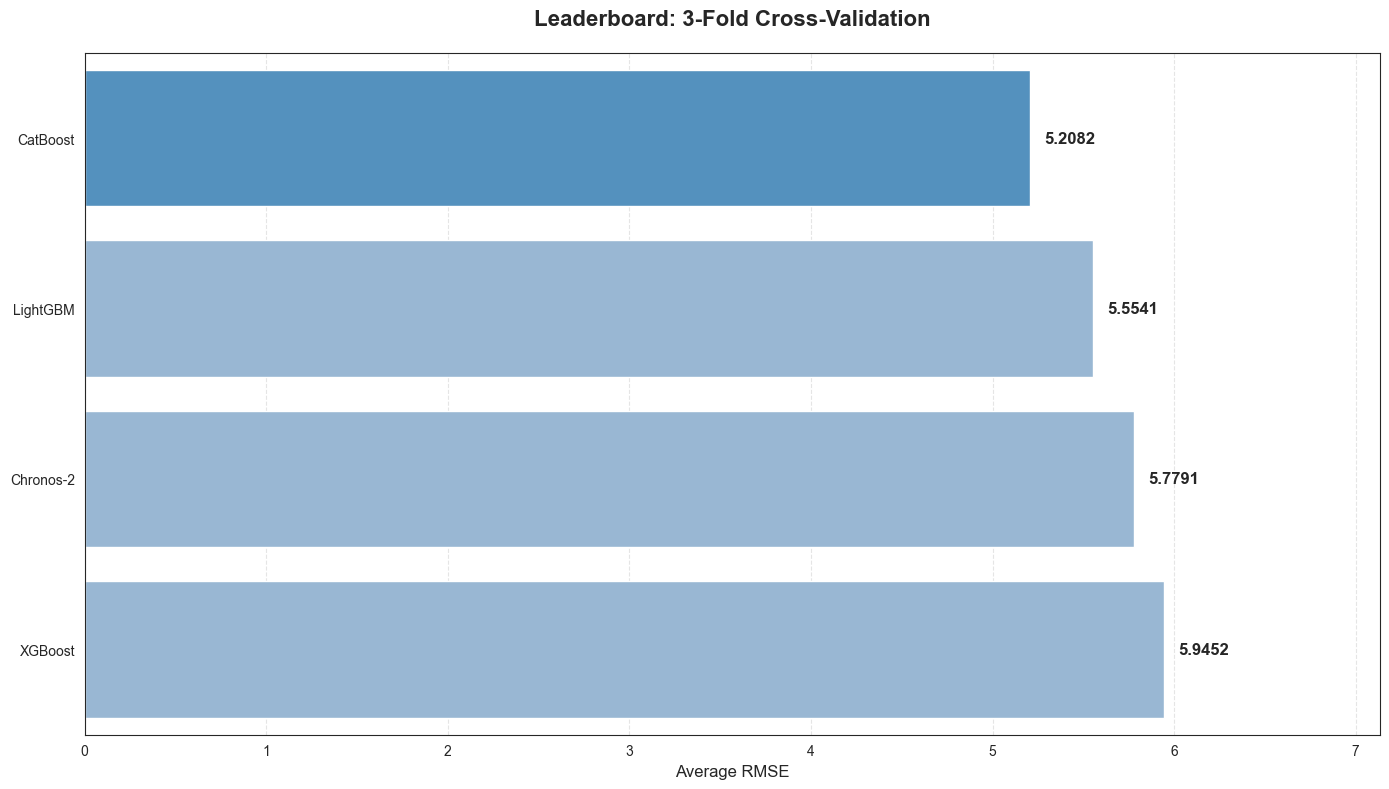

Overall Champion: CatBoost


In [28]:
df_leaderboard = pd.DataFrame(list(results.items()), columns=['Model', 'RMSE'])
df_leaderboard = df_leaderboard.sort_values(by='RMSE', ascending=True)

plt.figure(figsize=(14, 8))
winner_overall = df_leaderboard.iloc[0]['Model']
colors = [target_blue if model == winner_overall else '#8FB7DD' for model in df_leaderboard['Model']]

ax = sns.barplot(
    data=df_leaderboard,
    x='RMSE',
    y='Model',
    palette=colors,
    hue='Model',
    legend=False
)

# Bar Labels
for i in ax.containers:
    ax.bar_label(i, fmt='%.4f', padding=10, fontsize=12, fontweight='bold')

plt.title('Leaderboard: 3-Fold Cross-Validation', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Average RMSE', fontsize=12)
plt.ylabel('', fontsize=12)
plt.xlim(0, df_leaderboard['RMSE'].max() * 1.2)
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('images/model_leaderboard.png')
plt.show()

print(f"Overall Champion: {winner_overall}")

In [ ]:
def objective(trial):
    # Suggest the model type first
    model_type = trial.suggest_categorical('model_type', models_to_test)

    # Shared or model-specific parameters
    n_estimators = trial.suggest_int('n_estimators', 100, 2000, step=100)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1, log=True)
    depth = trial.suggest_int('max_depth', 3, 8)
    l2_reg = trial.suggest_float('l2_reg', 1e-2, 10.0, log=True)

    tscv = TimeSeriesSplit(n_splits=x_fold_cv, test_size=horizon_rows)
    cv_scores = []
    fold_best_ntrees = []

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train_full)):
        X_tr, X_va = X_train_full.iloc[train_idx], X_train_full.iloc[val_idx]
        y_tr, y_va = y_train_full.iloc[train_idx], y_train_full.iloc[val_idx]

        if model_type == 'XGBoost':
            model = xgb.XGBRegressor(
                learning_rate=learning_rate, max_depth=depth, reg_lambda=l2_reg,
                n_estimators=n_estimators, early_stopping_rounds=30,
                tree_method='hist', enable_categorical=True,
                random_state=42, verbosity=0
            )
            model.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], verbose=False)
            fold_best_ntrees.append(model.best_iteration)

        elif model_type == 'CatBoost':
            model = CatBoostRegressor(
                learning_rate=learning_rate, depth=depth, l2_leaf_reg=l2_reg,
                iterations=n_estimators, early_stopping_rounds=30,
                random_seed=42, verbose=False
            )
            model.fit(X_tr, y_tr, cat_features=categorical_features, eval_set=(X_va, y_va))
            fold_best_ntrees.append(model.get_best_iteration())

        elif model_type == 'LightGBM':
            model = lgb.LGBMRegressor(
                learning_rate=learning_rate, max_depth=depth, reg_lambda=l2_reg,
                n_estimators=n_estimators, random_state=42, verbose=-1
            )
            model.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], callbacks=[lgb.early_stopping(30)])
            fold_best_ntrees.append(model.best_iteration_)

        score = root_mean_squared_error(y_va, model.predict(X_va))
        cv_scores.append(score)

        trial.report(np.mean(cv_scores), step=fold)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    # Save the best iteration average so we can retrain later
    avg_ntree = int(np.mean(fold_best_ntrees))
    trial.set_user_attr("best_ntree", avg_ntree)

    return np.mean(cv_scores)

study = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(multivariate=True, seed=42),
    pruner=optuna.pruners.HyperbandPruner(
        min_resource=1, max_resource=3, reduction_factor=3
    )
)

study.optimize(objective, n_trials=100)

print(f"Best Model Type: {study.best_params['model_type']}")
print(f"Best RMSE: {study.best_value:.4f}")
print(f"Best Hyperparameters: {study.best_params}")

/Users/luisgrewe/Documents/StockSalesPrediction/.venv/lib/python3.13/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-12-28 23:31:16,001] A new study created in memory with name: no-name-d1a3aaf4-d15d-42b0-b12b-cbc30fb3de93
[I 2025-12-28 23:31:19,016] Trial 0 finished with value: 5.156248646323341 and parameters: {'model_type': 'XGBoost', 'n_estimators': 1200, 'learning_rate': 0.014322493718230255, 'max_depth': 3, 'l2_reg': 0.014936568554617643}. Best is trial 0 with value: 5.156248646323341.
[I 2025-12-28 23:31:20,758] Trial 1 finished with value: 5.34517529261242 and parameters: {'model_type': 'CatBoost', 'n_estimators': 100, 'learning_rate': 0.09330606024425668, 'max_depth': 7, 'l2_reg': 0.04335281794951565}. Best is trial 0 with value: 5.156248646323341.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[175]	valid_0's l2: 25.113
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[109]	valid_0's l2: 11.6519
Training until validation scores don't improve for 30 rounds


[I 2025-12-28 23:31:22,788] Trial 2 finished with value: 5.427120000468318 and parameters: {'model_type': 'LightGBM', 'n_estimators': 1100, 'learning_rate': 0.027036160666620016, 'max_depth': 4, 'l2_reg': 0.6847920095574782}. Best is trial 0 with value: 5.156248646323341.


Early stopping, best iteration is:
[514]	valid_0's l2: 61.7259
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[82]	valid_0's l2: 26.0725
Training until validation scores don't improve for 30 rounds


[I 2025-12-28 23:31:23,379] Trial 3 pruned. 


Early stopping, best iteration is:
[117]	valid_0's l2: 11.2528
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[282]	valid_0's l2: 29.1
Training until validation scores don't improve for 30 rounds


[I 2025-12-28 23:31:26,493] Trial 4 pruned. 


Early stopping, best iteration is:
[285]	valid_0's l2: 10.8715


[I 2025-12-28 23:31:36,916] Trial 5 finished with value: 5.349344815773301 and parameters: {'model_type': 'CatBoost', 'n_estimators': 1400, 'learning_rate': 0.027551959649510765, 'max_depth': 3, 'l2_reg': 0.3058656666978527}. Best is trial 0 with value: 5.156248646323341.
[I 2025-12-28 23:31:39,263] Trial 6 finished with value: 5.729322985935031 and parameters: {'model_type': 'XGBoost', 'n_estimators': 1400, 'learning_rate': 0.02049798052095018, 'max_depth': 6, 'l2_reg': 0.4366473592979634}. Best is trial 0 with value: 5.156248646323341.
[I 2025-12-28 23:31:40,188] Trial 7 pruned. 
[I 2025-12-28 23:31:41,131] Trial 8 pruned. 


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[100]	valid_0's l2: 23.0219
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[154]	valid_0's l2: 11.5297
Training until validation scores don't improve for 30 rounds


[I 2025-12-28 23:31:42,050] Trial 9 finished with value: 5.305984642099337 and parameters: {'model_type': 'LightGBM', 'n_estimators': 300, 'learning_rate': 0.06341572775495277, 'max_depth': 3, 'l2_reg': 9.133995846860973}. Best is trial 0 with value: 5.156248646323341.


Did not meet early stopping. Best iteration is:
[300]	valid_0's l2: 59.6647


[I 2025-12-28 23:31:42,982] Trial 10 pruned. 


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[66]	valid_0's l2: 23.4221
Training until validation scores don't improve for 30 rounds


[I 2025-12-28 23:31:43,483] Trial 11 finished with value: 5.371364439814697 and parameters: {'model_type': 'LightGBM', 'n_estimators': 100, 'learning_rate': 0.06996007807948054, 'max_depth': 3, 'l2_reg': 4.928119389613962}. Best is trial 0 with value: 5.156248646323341.


Did not meet early stopping. Best iteration is:
[88]	valid_0's l2: 11.369
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's l2: 62.4519


[I 2025-12-28 23:31:46,414] Trial 12 finished with value: 5.146194341496009 and parameters: {'model_type': 'XGBoost', 'n_estimators': 1900, 'learning_rate': 0.018345367201103985, 'max_depth': 3, 'l2_reg': 0.012892015155135028}. Best is trial 12 with value: 5.146194341496009.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[295]	valid_0's l2: 24.8238
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[189]	valid_0's l2: 11.7283
Training until validation scores don't improve for 30 rounds


[I 2025-12-28 23:31:49,135] Trial 13 finished with value: 5.443394540390334 and parameters: {'model_type': 'LightGBM', 'n_estimators': 1700, 'learning_rate': 0.015864514347295244, 'max_depth': 4, 'l2_reg': 0.022255617808525845}. Best is trial 12 with value: 5.146194341496009.


Early stopping, best iteration is:
[746]	valid_0's l2: 62.7767


[I 2025-12-28 23:31:50,743] Trial 14 pruned. 
[I 2025-12-28 23:31:51,544] Trial 15 finished with value: 5.358533413397708 and parameters: {'model_type': 'XGBoost', 'n_estimators': 1700, 'learning_rate': 0.06444316367677148, 'max_depth': 4, 'l2_reg': 0.04547935312031889}. Best is trial 12 with value: 5.146194341496009.
[I 2025-12-28 23:31:59,011] Trial 16 finished with value: 5.481932239027448 and parameters: {'model_type': 'CatBoost', 'n_estimators': 1200, 'learning_rate': 0.02308728697693398, 'max_depth': 3, 'l2_reg': 0.010563145411752265}. Best is trial 12 with value: 5.146194341496009.
[I 2025-12-28 23:32:16,954] Trial 17 finished with value: 5.286095810246333 and parameters: {'model_type': 'CatBoost', 'n_estimators': 2000, 'learning_rate': 0.01367418777761231, 'max_depth': 6, 'l2_reg': 0.010445638039462385}. Best is trial 12 with value: 5.146194341496009.
[I 2025-12-28 23:32:19,640] Trial 18 finished with value: 5.663266443862342 and parameters: {'model_type': 'XGBoost', 'n_estimat

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[192]	valid_0's l2: 28.3757
Training until validation scores don't improve for 30 rounds


[I 2025-12-28 23:32:42,562] Trial 22 pruned. 


Early stopping, best iteration is:
[165]	valid_0's l2: 11.2945


[I 2025-12-28 23:33:05,499] Trial 23 finished with value: 5.300310707614183 and parameters: {'model_type': 'CatBoost', 'n_estimators': 1700, 'learning_rate': 0.012748497304092457, 'max_depth': 8, 'l2_reg': 0.06458992233413335}. Best is trial 12 with value: 5.146194341496009.
[I 2025-12-28 23:33:11,346] Trial 24 finished with value: 5.331688302012496 and parameters: {'model_type': 'CatBoost', 'n_estimators': 2000, 'learning_rate': 0.038120759793390586, 'max_depth': 6, 'l2_reg': 0.01683167919737518}. Best is trial 12 with value: 5.146194341496009.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[375]	valid_0's l2: 22.613
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[506]	valid_0's l2: 11.1893
Training until validation scores don't improve for 30 rounds


[I 2025-12-28 23:33:13,728] Trial 25 finished with value: 5.321664386802893 and parameters: {'model_type': 'LightGBM', 'n_estimators': 1000, 'learning_rate': 0.012821973496522228, 'max_depth': 3, 'l2_reg': 0.01925626310830837}. Best is trial 12 with value: 5.146194341496009.


Early stopping, best iteration is:
[708]	valid_0's l2: 61.8525


[I 2025-12-28 23:33:14,370] Trial 26 pruned. 
[I 2025-12-28 23:33:15,459] Trial 27 pruned. 
[I 2025-12-28 23:33:25,885] Trial 28 finished with value: 5.293610296113769 and parameters: {'model_type': 'CatBoost', 'n_estimators': 1900, 'learning_rate': 0.029499610807816157, 'max_depth': 8, 'l2_reg': 0.015220770258608319}. Best is trial 12 with value: 5.146194341496009.
[I 2025-12-28 23:33:36,556] Trial 29 finished with value: 5.2599274256044195 and parameters: {'model_type': 'CatBoost', 'n_estimators': 1100, 'learning_rate': 0.022256642430291042, 'max_depth': 6, 'l2_reg': 0.016272523195695224}. Best is trial 12 with value: 5.146194341496009.
[I 2025-12-28 23:33:46,478] Trial 30 finished with value: 5.243063822697221 and parameters: {'model_type': 'CatBoost', 'n_estimators': 700, 'learning_rate': 0.03627570764041255, 'max_depth': 7, 'l2_reg': 1.32394629829207}. Best is trial 12 with value: 5.146194341496009.
[I 2025-12-28 23:33:59,445] Trial 31 finished with value: 5.309594775261983 and pa

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[78]	valid_0's l2: 27.952
Training until validation scores don't improve for 30 rounds


[I 2025-12-28 23:34:15,653] Trial 34 pruned. 


Early stopping, best iteration is:
[50]	valid_0's l2: 11.5001
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[44]	valid_0's l2: 25.3127
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[129]	valid_0's l2: 11.1563
Training until validation scores don't improve for 30 rounds


[I 2025-12-28 23:34:16,637] Trial 35 finished with value: 5.37641813295086 and parameters: {'model_type': 'LightGBM', 'n_estimators': 200, 'learning_rate': 0.06215883688025167, 'max_depth': 4, 'l2_reg': 0.012548881889777595}. Best is trial 12 with value: 5.146194341496009.


Did not meet early stopping. Best iteration is:
[200]	valid_0's l2: 60.1861


[I 2025-12-28 23:34:17,600] Trial 36 pruned. 
[I 2025-12-28 23:34:19,093] Trial 37 pruned. 


Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 35.2599
Training until validation scores don't improve for 30 rounds


[I 2025-12-28 23:34:19,601] Trial 38 pruned. 


Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 17.6343


[I 2025-12-28 23:37:15,782] Trial 39 pruned. 


In [ ]:
# Plot parallel coordinates
vis.plot_parallel_coordinate(study).show()

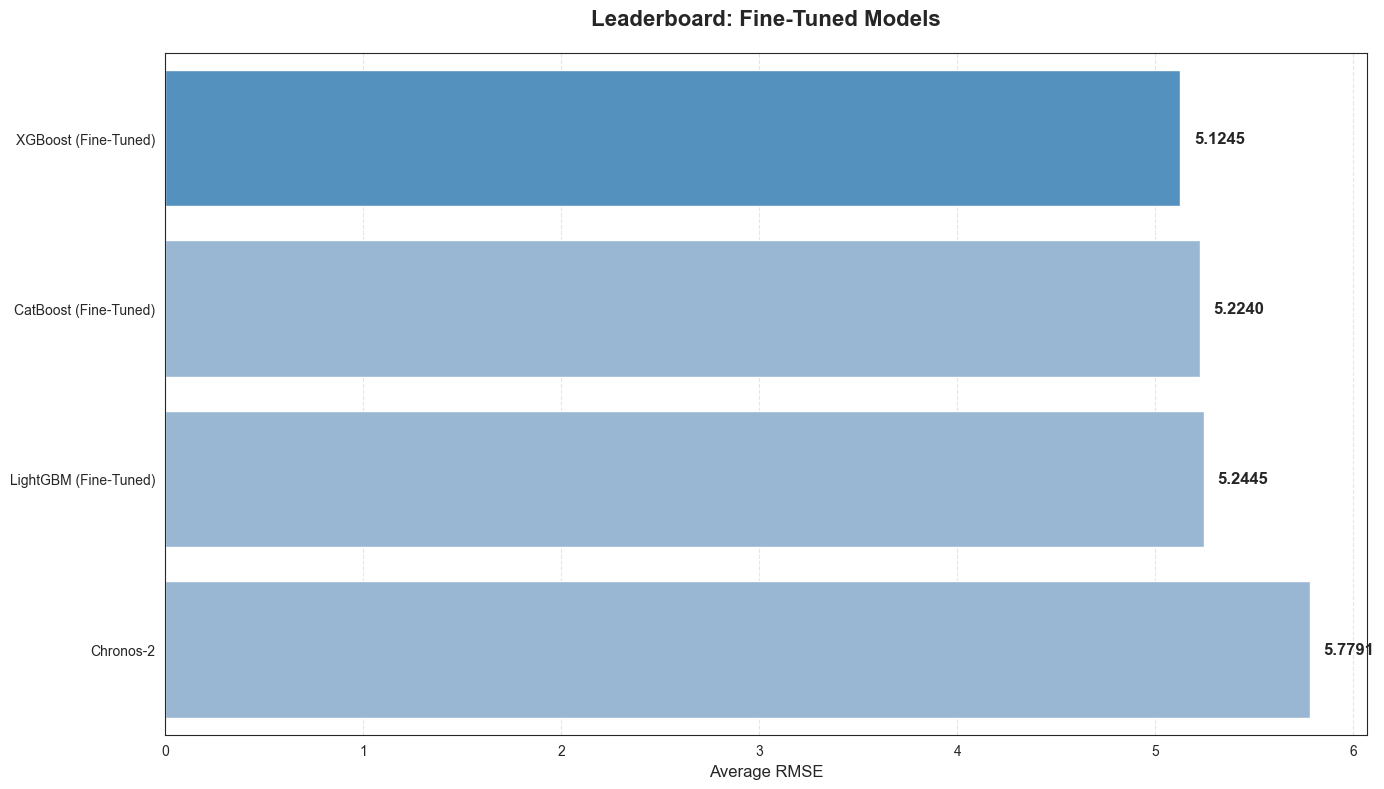

In [ ]:
final_leaderboard_data = []

for model_name, baseline_rmse in results.items():
    if model_name in models_to_test:
        # Get all successful trials for this specific model type
        model_trials = [
            t.value for t in study.trials
            if t.state == optuna.trial.TrialState.COMPLETE
            and t.params.get('model_type') == model_name
        ]

        if model_trials:
            best_tuned_rmse = min(model_trials)
            # Add with a marker
            final_leaderboard_data.append({
                'Model': f"{model_name} (Fine-Tuned)",
                'RMSE': best_tuned_rmse,
                'Is_Tuned': True
            })
        else:
            # If for some reason no trial succeeded, keep baseline
            final_leaderboard_data.append({'Model': model_name, 'RMSE': baseline_rmse, 'Is_Tuned': False})
    else:
        # For non-tuned models (like Chronos 2)
        final_leaderboard_data.append({'Model': model_name, 'RMSE': baseline_rmse, 'Is_Tuned': False})

# Create and sort the DataFrame
df_final = pd.DataFrame(final_leaderboard_data).sort_values(by='RMSE', ascending=True)

plt.figure(figsize=(14, 8))
winner_overall = df_final.iloc[0]['Model']


ax = sns.barplot(
    data=df_final,
    x='RMSE',
    y='Model',
    palette=colors,
    hue='Model',
    legend=False
)

# Add data labels
for i in ax.containers:
    ax.bar_label(i, fmt='%.4f', padding=10, fontsize=12, fontweight='bold')

plt.title('Leaderboard: Fine-Tuned Models', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Average RMSE', fontsize=12)
plt.ylabel('', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('images/model_leaderboard_fine_tuned.png')
plt.show()

In [ ]:
# Extract best values
best_params = study.best_params.copy()
best_ntree = study.best_trial.user_attrs["best_ntree"]

fine_tuned_winner = best_params.pop('model_type')
print(f"Best Model Type: {fine_tuned_winner}")

# Handle parameter name mapping (L2 Regularization)
l2_val = best_params.pop('l2_reg', None)

if fine_tuned_winner == 'XGBoost':
    if l2_val is not None: best_params['reg_lambda'] = l2_val
    final_model = xgb.XGBRegressor(
        **best_params,
        tree_method='hist',
        enable_categorical=True,
        random_state=42
    )

elif fine_tuned_winner == 'CatBoost':
    if l2_val is not None: best_params['l2_leaf_reg'] = l2_val
    final_model = CatBoostRegressor(
        **best_params,
        random_seed=42,
        verbose=False,
        cat_features=categorical_features
    )

elif fine_tuned_winner == 'LightGBM':
    if l2_val is not None: best_params['reg_lambda'] = l2_val
    final_model = lgb.LGBMRegressor(
        **best_params,
        random_state=42,
        verbose=-1
    )

# Final Fit
final_model.fit(X_train_full, y_train_full)

print(f"Winner: {winner_overall}")
print(f"Best iteration count: {best_ntree}")

Best Model Type: XGBoost
Winner: XGBoost (Fine-Tuned)
Best iteration count: 509


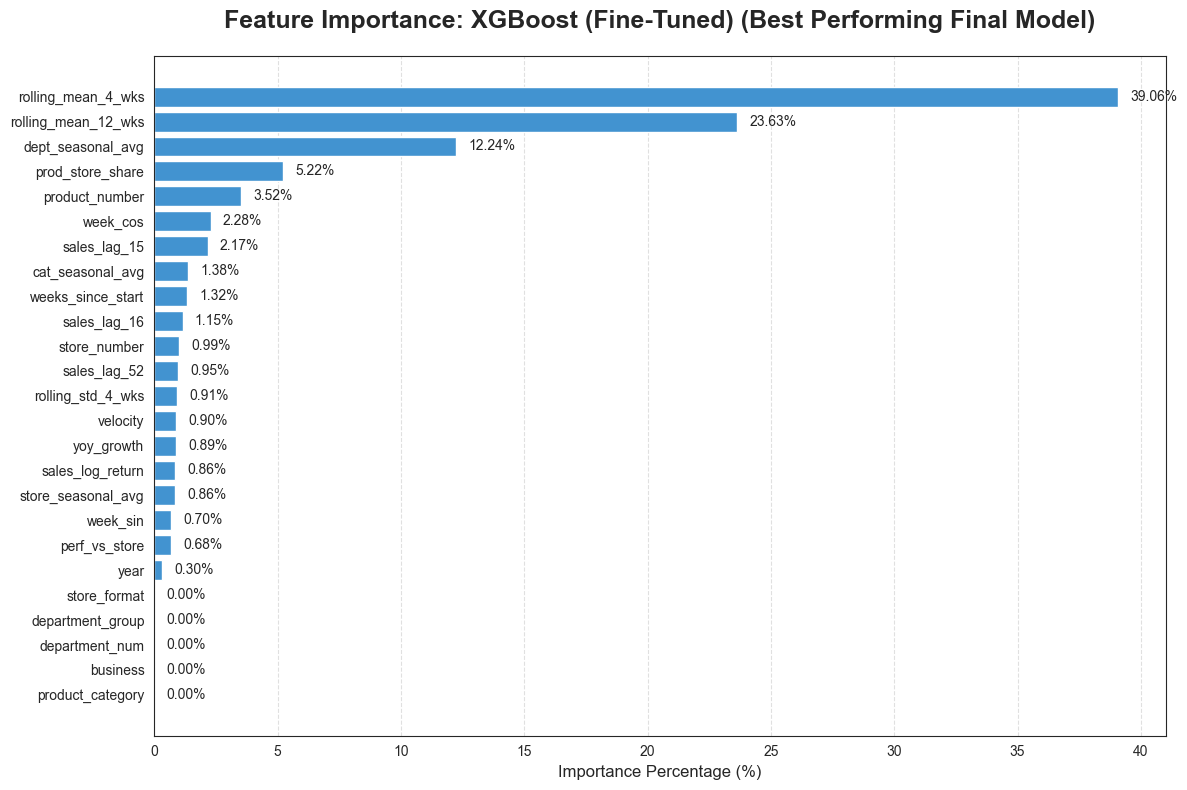

In [ ]:
feature_names = X_train_full.columns

if fine_tuned_winner == 'CatBoost':
    importances = final_model.get_feature_importance()
    color = '#27ae60'
elif fine_tuned_winner == 'XGBoost':
    importances = final_model.feature_importances_
    color = '#2980b9'
elif fine_tuned_winner == 'LightGBM':
    importances = final_model.feature_importances_
    color = '#f39c12'

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Normalize importances of the features
importance_df['Importance'] = (importance_df['Importance'] / importance_df['Importance'].sum()) * 100
importance_df = importance_df.sort_values(by='Importance', ascending=True)

plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color="#4293D0")

plt.title(f'Feature Importance: {winner_overall} (Best Performing Final Model)', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Importance Percentage (%)', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)

for index, value in enumerate(importance_df['Importance']):
    plt.text(value + 0.5, index, f'{value:.2f}%', va='center', fontsize=10)

plt.tight_layout()
save_path = f"images/feature_importance_{winner_overall}.png"
plt.savefig(save_path)
plt.show()

## Test Data

In [ ]:
# Prepare the test data
X_test_engineered = data_loader.prepare_test_features(df["train"], df["test"])

# Align the columns with the training data
feature_cols = X_train_full.columns.tolist()
X_test_predict = X_test_engineered[feature_cols].copy()

# Align Categorical Dtypes
if winner_overall != 'CatBoost':
    for col in categorical_features:
        # 1. Ensure the column exists in test
        if col in X_test_predict.columns:
            # 2. Force the test column to match the training column's category dtype exactly
            X_test_predict[col] = X_test_predict[col].astype(X_train_full[col].dtype)

            # 3. Handle any potential "unseen" categories in the test set by setting them to NaN
            # (XGBoost handles NaNs in categories automatically)
            X_test_predict[col] = X_test_predict[col].where(
                X_test_predict[col].isin(X_train_full[col].cat.categories)
            )

# Verify no column-order mismatch (XGBoost requires columns in same order as training)
X_test_predict = X_test_predict[X_train_full.columns]

# Generate Final Predictions
test_predictions = final_model.predict(X_test_predict)

# Post-Processing
test_predictions = np.maximum(test_predictions, 0)

df_results = X_test_engineered[['store_number', 'product_number', 'product_category', 'business', 'department_num', 'department_group', 'store_format', 'week']].copy()
df_results['sales'] = test_predictions

df_results_preprocessed = data_loader.preprocessing(df_results)

output_path = f'results/final_sales_predictions_{winner_overall}.xlsx'
df_results.to_excel(output_path, index=False)

print(f"Predictions saved to {output_path}")
print(df_results.head())

Predictions saved to results/final_sales_predictions_XGBoost (Fine-Tuned).xlsx
     store_number  product_number  product_category  business  department_num  \
142             0             126            301202      3012              30   
143             0             126            301202      3012              30   
144             0             126            301202      3012              30   
145             0             126            301202      3012              30   
146             0             126            301202      3012              30   

     department_group  store_format       week     sales  
142                11             1 2024-12-30  2.323622  
143                11             1 2025-01-06  1.184648  
144                11             1 2025-01-13  1.519816  
145                11             1 2025-01-20  1.675754  
146                11             1 2025-01-27  2.089254  


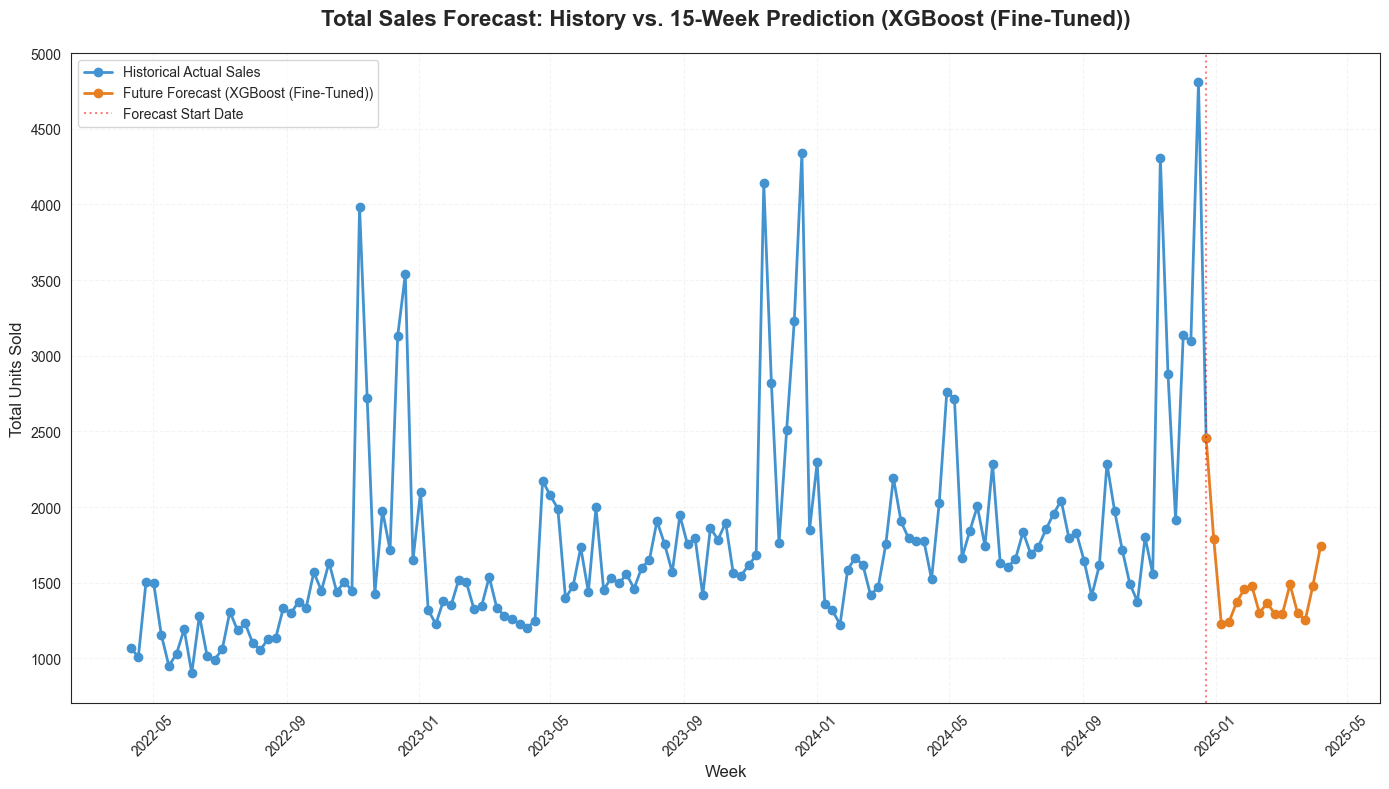

In [ ]:
# Prepare Historical Data
history_weeks = data_loader.preprocessing(df['train'])['week']
df_history = pd.DataFrame({
    'week': history_weeks.loc[X_train_full.index],
    'sales': y_train_full
})
weekly_actuals = df_history.groupby('week')['sales'].sum().reset_index().sort_values('week')

weekly_forecast = df_results.groupby('week')['sales'].sum().reset_index().sort_values('week')

# Get the very last point of history
last_actual_point = weekly_actuals.tail(1)

# Attach it to the start of the forecast
weekly_forecast_connected = pd.concat([last_actual_point, weekly_forecast], ignore_index=True)

plt.figure(figsize=(14, 8))

# Plot Historical Sales
plt.plot(weekly_actuals['week'], weekly_actuals['sales'],
         label='Historical Actual Sales', color='#4293D0', linewidth=2, marker='o')

# Plot the Future
plt.plot(weekly_forecast_connected['week'], weekly_forecast_connected['sales'],
         label=f'Future Forecast ({winner_overall})', color='#e67e22', linestyle='--', linewidth=2, marker='o')

# Split Line
today = weekly_actuals['week'].max()
plt.axvline(x=today, color='red', linestyle=':', alpha=0.5, label='Forecast Start Date')

# Chart Styling
plt.title(f"Total Sales Forecast: History vs. 15-Week Prediction ({winner_overall})", fontsize=16, pad=20, fontweight='bold')
plt.xlabel("Week", fontsize=12)
plt.ylabel("Total Units Sold", fontsize=12)
plt.legend(loc='upper left', frameon=True)
plt.grid(True, linestyle='--', alpha=0.2)
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('images/sales_forecast_connected.png')
plt.show()

## Trends in Forecast Data

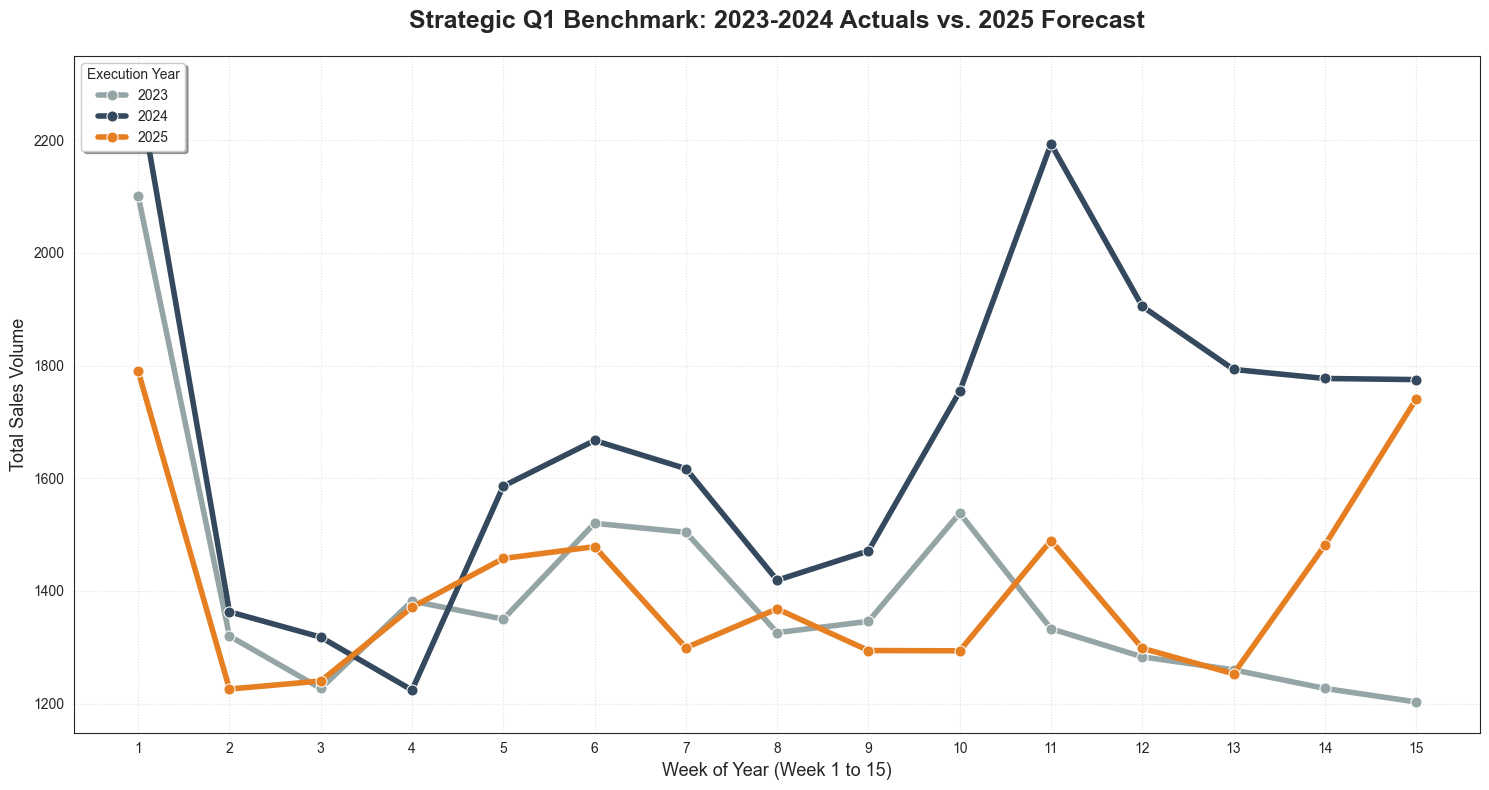

In [ ]:
# Historical Data
history = X_train_preprocessed[X_train_preprocessed['year'].isin([2023, 2024])].copy()
history['week_num'] = history['week_of_year']

# Group historical sales
history_q1 = history[history['week_num'] <= 15].groupby(['year', 'week_num'])['sales'].sum().reset_index()

# Prepare Forecast Data
forecast = df_results_preprocessed.copy()
forecast['week_num'] = forecast['week_of_year']

# Group forecast sales
forecast_q1 = forecast.groupby(['year', 'week_num'])['sales'].sum().reset_index()
forecast_q1.columns = ['year', 'week_num', 'sales']

# Combine Actuals and Forecast
comparison_df = pd.concat([history_q1, forecast_q1])

plt.figure(figsize=(15, 8))

# Define a clear color palette: 2023 (Light), 2024 (Dark), 2025 (Highlight)
custom_palette = {2023: '#95a5a6', 2024: '#34495e', 2025: '#e67e22'}

sns.lineplot(
    data=comparison_df,
    x='week_num',
    y='sales',
    hue='year',
    palette=custom_palette,
    linewidth=4,
    marker='o',
    markersize=8
)

# Chart Styling
plt.title('Strategic Q1 Benchmark: 2023-2024 Actuals vs. 2025 Forecast', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Week of Year (Week 1 to 15)', fontsize=13)
plt.ylabel('Total Sales Volume', fontsize=13)
plt.xticks(range(1, 16))
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend(title="Execution Year", loc='upper left', frameon=True, shadow=True)

plt.tight_layout()
plt.savefig("images/benchmark_yoy.png")
plt.show()

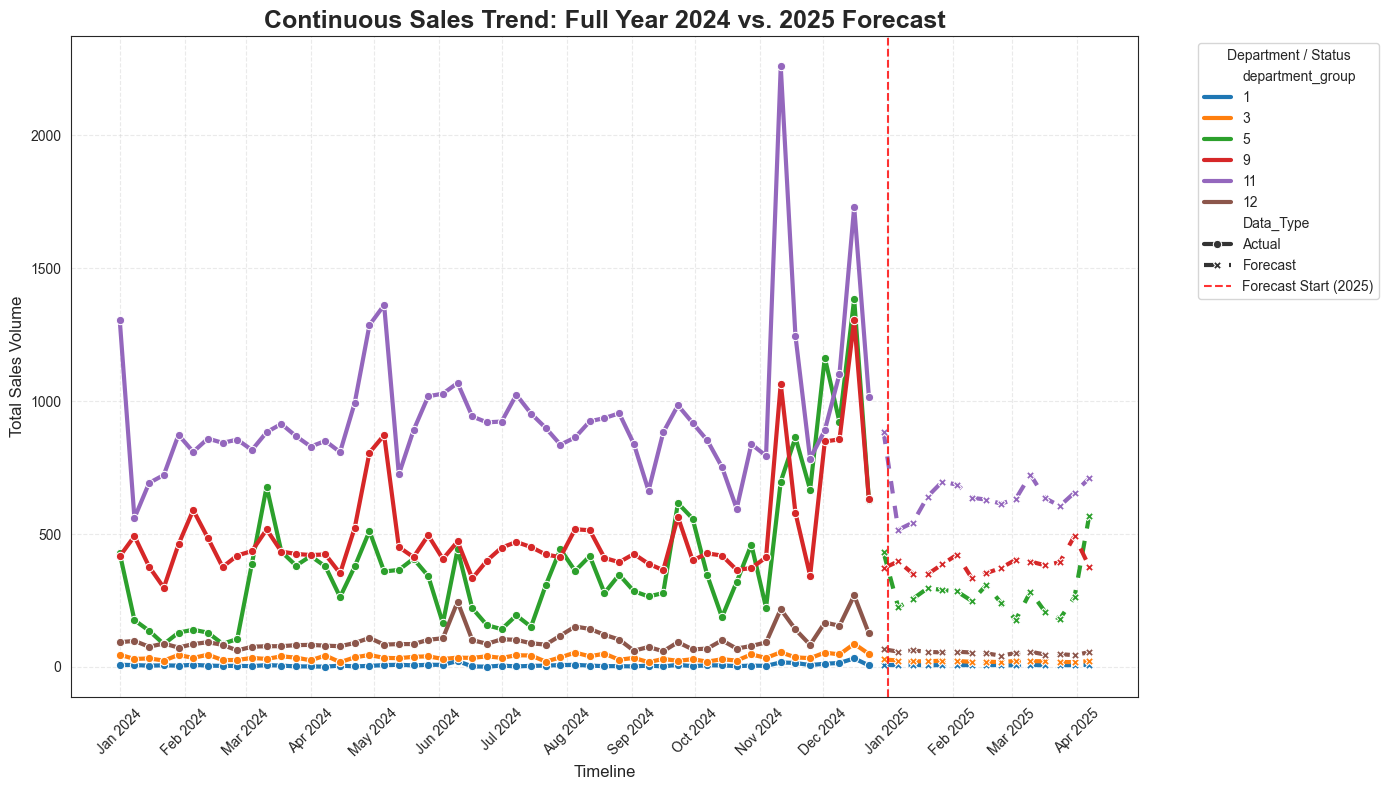

In [ ]:
target_col = data_loader.get_target_col()
date_col = data_loader.get_date_col()

history_df = X_train_engineered.copy()

# Filter for the year 2024 to keep the transition clear
history_2024 = history_df[history_df[date_col].dt.year == 2024].copy()

# Group by date and department to get the total volume per week
seasonal_sum = history_2024.groupby([date_col, 'department_group'])[target_col].sum().reset_index()
seasonal_sum['Data_Type'] = 'Actual'

# Create a copy of the test features and add final predictions
X_test_plot = X_test_engineered.copy()
X_test_plot[target_col] = test_predictions

# Group by date and department
forecast_sum = X_test_plot.groupby([date_col, 'department_group'])[target_col].sum().reset_index()
forecast_sum['Data_Type'] = 'Forecast'

combined_plot_data = pd.concat([seasonal_sum, forecast_sum], axis=0).sort_values(by=date_col)

plt.figure(figsize=(14, 8))

# Lineplot with different styles for Actual vs Forecast
sns.lineplot(
    data=combined_plot_data,
    x=date_col,
    y=target_col,
    hue='department_group',
    style='Data_Type',
    markers=True,
    dashes={'Actual': '', 'Forecast': (3, 3)},
    linewidth=3,
    palette="tab10"
)

# Add a vertical line for the New Year transition
plt.axvline(pd.Timestamp('2025-01-01'), color='red', linestyle='--', alpha=0.8, label='Forecast Start (2025)')

# Formatting
plt.title('Continuous Sales Trend: Full Year 2024 vs. 2025 Forecast', fontsize=18, fontweight='bold')
plt.ylabel('Total Sales Volume', fontsize=12)
plt.xlabel('Timeline', fontsize=12)

# Format the X-axis to show Month and Year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=45)

plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(title='Department / Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("images/sales_trend_per_department.png")
plt.show()

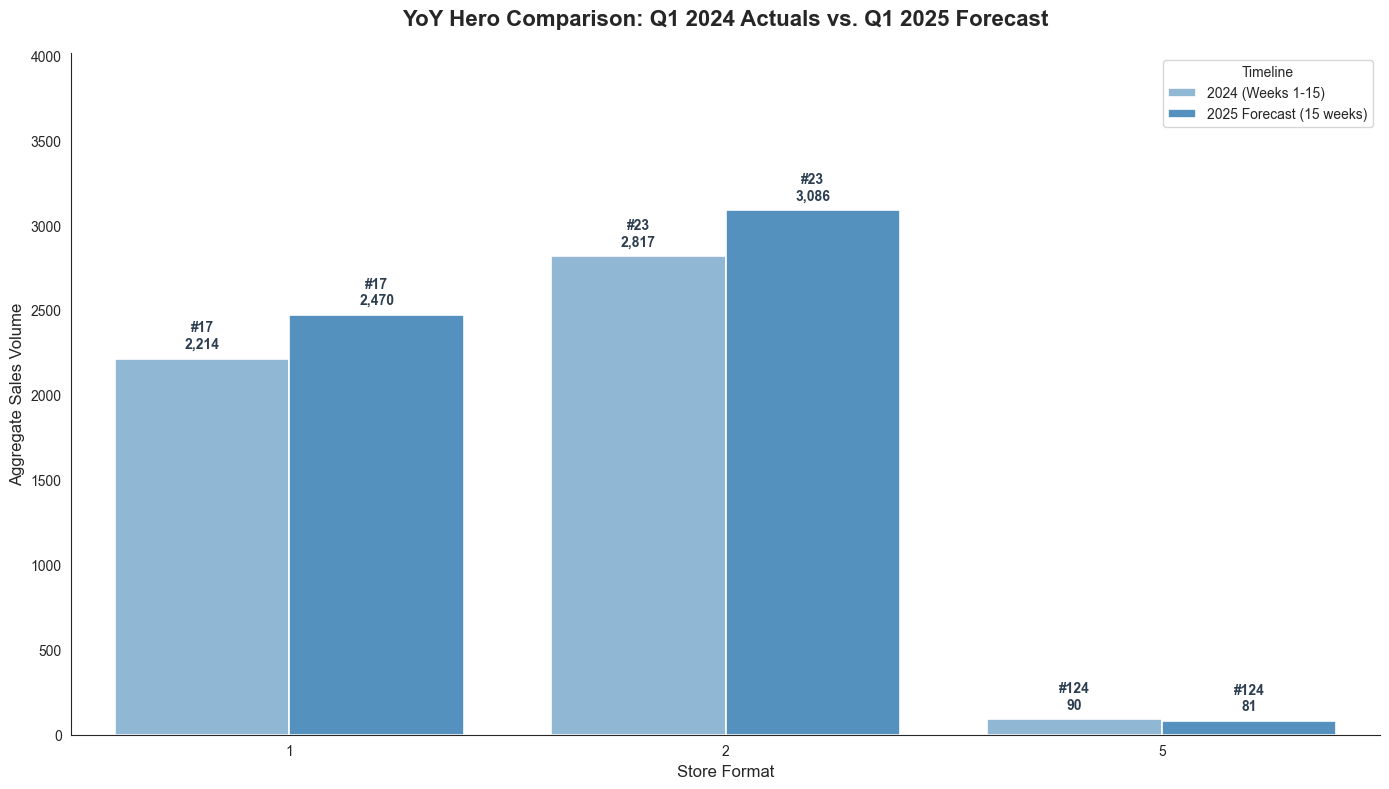

In [ ]:
start_date_2024 = pd.Timestamp('2024-01-01')
end_date_2024 = start_date_2024 + pd.Timedelta(weeks=horizon)

actual_2024_full = X_train_preprocessed[X_train_preprocessed['year'] == 2024].copy()
# Ensure indexing is aligned correctly for the target
actual_2024_full['sales'] = y_train_full.loc[actual_2024_full.index]

# Filter for the identical seasonal window (Weeks 1-15)
df_2024_15w = actual_2024_full[
    (actual_2024_full[date_col] >= start_date_2024) & 
    (actual_2024_full[date_col] < end_date_2024)
].copy()

# Identify 2024 Hero for 15 weeks range
hero_2024 = (
    df_2024_15w.groupby(['store_format', 'product_number'])['sales']
    .sum().reset_index()
    .sort_values(['store_format', 'sales'], ascending=[True, False])
    .groupby('store_format').head(1)
)
hero_2024['Period'] = '2024 (Weeks 1-15)'

# Prepare 2025 Forecast (The full 15-week results)
hero_2025 = (
    df_results_preprocessed.groupby(['store_format', 'product_number'])['sales']
    .sum().reset_index()
    .sort_values(['store_format', 'sales'], ascending=[True, False])
    .groupby('store_format').head(1)
)
hero_2025['Period'] = "2025 Forecast (15 weeks)"

comparison_df = pd.concat([hero_2024, hero_2025])

plt.figure(figsize=(14, 8))
sns.set_style("white")

palette = {'2024 (Weeks 1-15)': "#84B9E0", "2025 Forecast (15 weeks)": "#4293D0"}

ax = sns.barplot(
    data=comparison_df, 
    x='store_format', 
    y='sales', 
    hue='Period', 
    palette=palette,
    edgecolor='white',
    linewidth=1.2
)

# Labels and Volume totals
for i, p in enumerate(ax.patches):
    height = p.get_height()
    if height > 0:
        num_formats = len(comparison_df['store_format'].unique())
        period_type = '2024 (Weeks 1-15)' if i < num_formats else "2025 Forecast (15 weeks)"
        fmt_name = comparison_df['store_format'].unique()[i % num_formats]
        
        row = comparison_df[
            (comparison_df['store_format'] == fmt_name) & 
            (comparison_df['Period'] == period_type)
        ]
        
        if not row.empty:
            sku_num = row['product_number'].values[0]
            plt.text(
                p.get_x() + p.get_width() / 2., 
                height + (comparison_df['sales'].max() * 0.015),
                f'#{int(sku_num)}\n{int(height):,}', 
                ha='center', va='bottom', 
                fontsize=10, fontweight='bold', color='#2c3e50'
            )

plt.title('YoY Hero Comparison: Q1 2024 Actuals vs. Q1 2025 Forecast', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Store Format', fontsize=12)
plt.ylabel('Aggregate Sales Volume', fontsize=12)
plt.legend(title='Timeline', loc='upper right', frameon=True)

plt.ylim(0, comparison_df['sales'].max() * 1.3)
sns.despine()
plt.tight_layout()

plt.savefig('images/hero_comparison_15w.png', dpi=300)
plt.show()

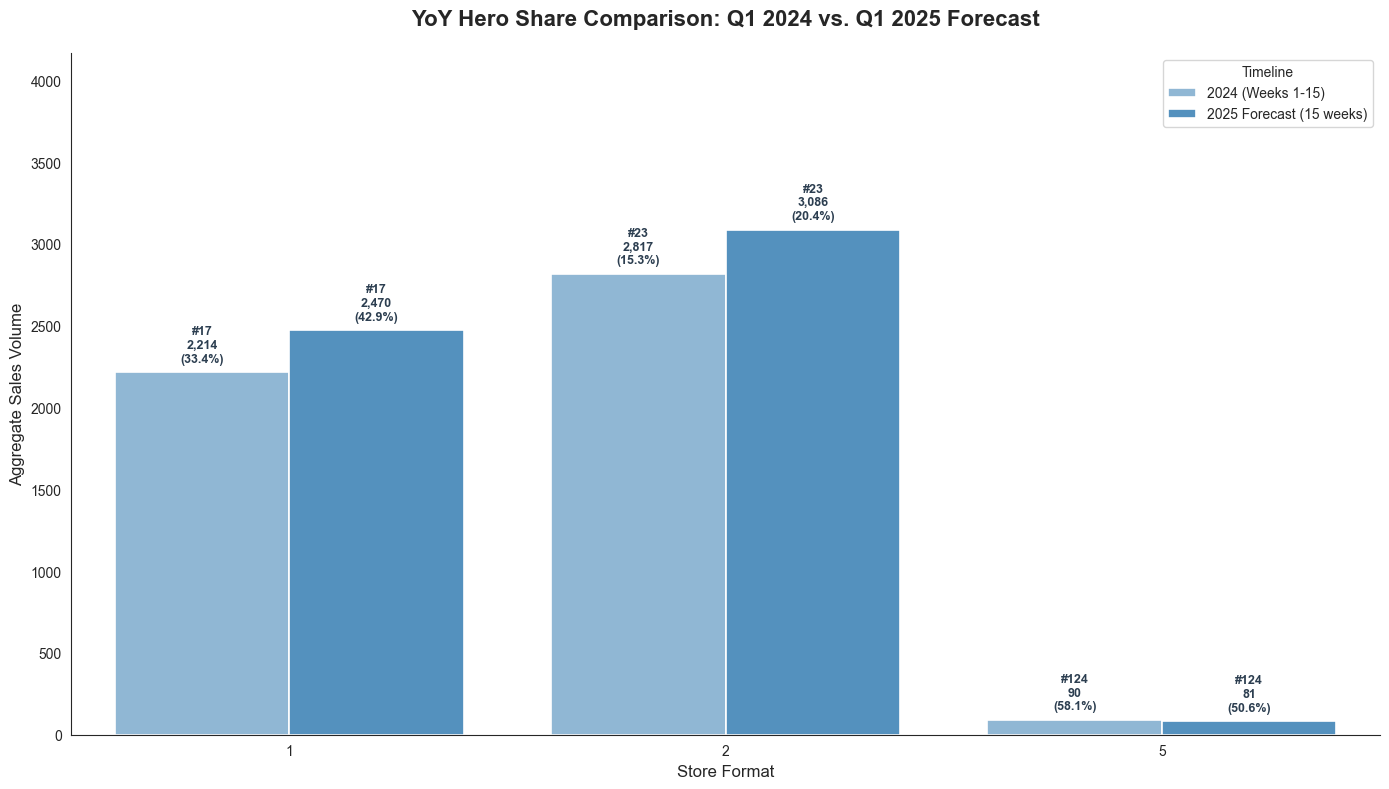

In [ ]:
start_date_2024 = pd.Timestamp('2024-01-01')
end_date_2024 = start_date_2024 + pd.Timedelta(weeks=horizon)

actual_2024_full = X_train_preprocessed[X_train_preprocessed['year'] == 2024].copy()
actual_2024_full['sales'] = y_train_full.loc[actual_2024_full.index]

df_2024_15w = actual_2024_full[
    (actual_2024_full[date_col] >= start_date_2024) & 
    (actual_2024_full[date_col] < end_date_2024)
].copy()

# Calculate Total Format Sales for the 15-week period (Denominator)
format_total_24 = df_2024_15w.groupby('store_format')['sales'].sum().reset_index().rename(columns={'sales': 'total_sales'})

hero_2024 = (
    df_2024_15w.groupby(['store_format', 'product_number'])['sales']
    .sum().reset_index()
    .sort_values(['store_format', 'sales'], ascending=[True, False])
    .groupby('store_format').head(1)
)

# Merge and Calculate Share
hero_2024 = hero_2024.merge(format_total_24, on='store_format')
hero_2024['share_pct'] = (hero_2024['sales'] / hero_2024['total_sales']) * 100
hero_2024['Period'] = '2024 (Weeks 1-15)'

# Calculate Total Predicted Sales for the forecast period (Denominator)
format_total_25 = df_results_preprocessed.groupby('store_format')['sales'].sum().reset_index().rename(columns={'sales': 'total_sales'})

hero_2025 = (
    df_results_preprocessed.groupby(['store_format', 'product_number'])['sales']
    .sum().reset_index()
    .sort_values(['store_format', 'sales'], ascending=[True, False])
    .groupby('store_format').head(1)
)

# Merge and Calculate Share
hero_2025 = hero_2025.merge(format_total_25, on='store_format')
hero_2025['share_pct'] = (hero_2025['sales'] / hero_2025['total_sales']) * 100
hero_2025['Period'] = "2025 Forecast (15 weeks)"

comparison_df = pd.concat([hero_2024, hero_2025])

plt.figure(figsize=(14, 8))
sns.set_style("white")

palette = {'2024 (Weeks 1-15)': "#84B9E0", "2025 Forecast (15 weeks)": "#4293D0"}

ax = sns.barplot(
    data=comparison_df, 
    x='store_format', 
    y='sales', 
    hue='Period', 
    palette=palette,
    edgecolor='white',
    linewidth=1.2
)

for i, p in enumerate(ax.patches):
    height = p.get_height()
    if height > 0:
        num_formats = len(comparison_df['store_format'].unique())
        period_type = '2024 (Weeks 1-15)' if i < num_formats else "2025 Forecast (15 weeks)"
        fmt_name = comparison_df['store_format'].unique()[i % num_formats]
        
        row = comparison_df[
            (comparison_df['store_format'] == fmt_name) & 
            (comparison_df['Period'] == period_type)
        ]
        
        if not row.empty:
            sku_num = row['product_number'].values[0]
            share = row['share_pct'].values[0]
            
            plt.text(
                p.get_x() + p.get_width() / 2., 
                height + (comparison_df['sales'].max() * 0.015),
                f'#{int(sku_num)}\n{int(height):,}\n({share:.1f}%)',
                ha='center', va='bottom', 
                fontsize=9, fontweight='bold', color='#2c3e50'
            )

plt.title('YoY Hero Share Comparison: Q1 2024 vs. Q1 2025 Forecast', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Store Format', fontsize=12)
plt.ylabel('Aggregate Sales Volume', fontsize=12)
plt.legend(title='Timeline', loc='upper right', frameon=True)

plt.ylim(0, comparison_df['sales'].max() * 1.35)
sns.despine()
plt.tight_layout()
plt.show()